In [1]:
import numpy as np 
from scipy import ndimage
from scipy.ndimage import convolve
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from math import exp
import os

ModuleNotFoundError: No module named 'cv2'

In [ ]:
pip install 

ATTENTION : Il faut nécessairement la version 1.20.0 de numpy et 3.5.1 de matplotlib pour exécuter le code suivant 

# 1A ModIA : Projet Detection de Contours 



* MUSSARD Cassandra 
* GHAMNIA Karima 
* COLIN Rémi 
* SONG Mickael

Ce projet combine différentes méthodes et techniques de traitement de signal et d'apprentissage automatique pour de la détection de contours. 

Dans un premier temps, on a commencé par parcourir les méthodes mathématiques les plus utilisées dans le domaine : Convolutions avec différents filtres (Sobel, Prewitt,..) pour calculer le gradien, le Laplacien, et la transformée de Hough.

Ensuite, on a utilisé des méthodes de Machine Learning: CNN, Random Forest, et Fine Tuning. Enfin, on a comparé les différents méthodes utilisées sur l'image ('lena.png')



# I - Détection de contours avec les méthodes classiques

### 1 - Méthodes basées sur le calcul du gradient :

Le calcul du gradient, est une des techniques les plus utilisées en traitement d'images pour la détection de contours. En calculant le gradient d'une image, on mesure la variation des pixels de cette dernière, ce qui permets d'identifier les changements d'intensité significatifs entre les pixels. 

Pour cela, on effectue des convolutions avec des filtres qui permettent de calculer la dérivée première de l'image. Dans ce notebook, on a utilisé les opérateurs suivants: Roberts, Prewitt et Sobel.

vecteur

Il est caractérisé par un module $G$ et une direction $\phi$ dans l’image :

$$ G = \sqrt{ (\frac{\delta{I(x,y)^2}}{\delta{x}} + \frac{\delta{I(x,y)}^2}{\delta{y}} )}$$

$$\phi = arctan(\frac{\delta{I(x,y)}}{\delta{x}} / \frac{\delta{I(x,y)}}{\delta{y}} )$$ 


## STEP 0 : Filtre gaussien 

D'abord, avant d'appliquer les différentes méthodes de détection de contours, on va toujours commencer par filtrer l'image d'origine, afin d'enlever le bruit ainsi que les détails indésirables de l'image, qui parfois peuvent conduire à une détection de contour érronée. On choisit donc d'utiliser un filtre gaussien qui va atténuer toutes variation indésirable avant de passer aux caluculs du gradient. 

On utilise un filtre gaussien pour sa distribution de probabilité normale, ce qui permet d'avoir un équilibre entre la suppression du bruit et la préservation des contours importants. D'autres filtres passe-bas peuvent être utilisés également.

Le filtre gaussien dans la suite, est définie par une matrice où chaque pixel a une valeur déterminée par la formule : 

$$ element(i,j) = exp  (-\frac{(i-x)^2+(j-y)^2}{2\sigma^2})$$

où $(x, y)$ est le centre du filtre et $\sigma$ est l'écart-type, qui contrôle la largeur de la distribution gaussienne.

In [2]:
def gaussian_kernel(image, kernel_size, sigma):
    kernel = np.empty((kernel_size, kernel_size))
    coeff_normalisant = 1 / (2.0 * np.pi * sigma**2)
    for i in range(kernel.shape[0]) :
        for j in range(kernel.shape[1]) :
            kernel[i,j] = coeff_normalisant*exp(-((i**2 + j**2) / (2.0*sigma**2))) 
    img_smoothed = convolve(image, kernel, mode='constant', cval=0.0)
    return img_smoothed

In [3]:
# Pour afficher les images 
def affiche(im1, im2):
    fig = plt.figure(figsize=(10, 5))
    grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

    # Afficher la première image 
    ax1 = fig.add_subplot(grid[0, 0])
    ax1.imshow(im1, cmap='gray')

    # Afficher la deuxième image 
    ax2 = fig.add_subplot(grid[0, 1])
    ax2.imshow(im2, cmap='gray')

In [4]:
current_path = os.getcwd()
image = Image.open(current_path+'/lena.png')
image_niveau_gris = image.convert('L')
filtered_img = gaussian_kernel(image_niveau_gris, 10 ,10)

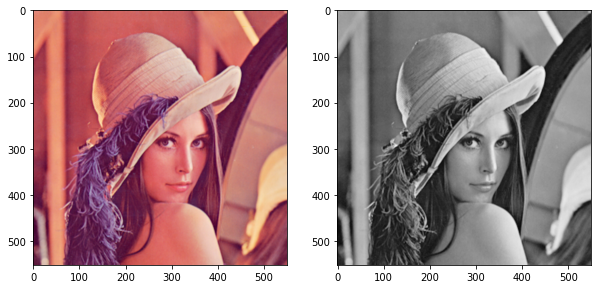

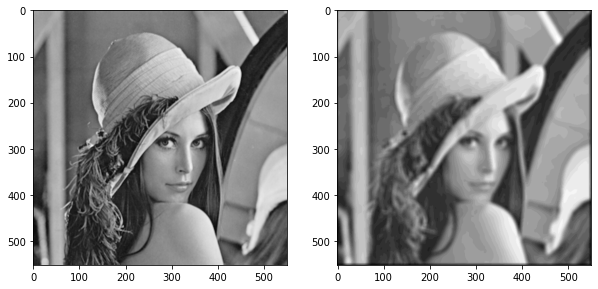

In [5]:
affiche(image, image_niveau_gris)
affiche(image_niveau_gris, filtered_img)

#### 1.1 - Opérateur de Roberts 
Cet opérateur utilise deux masques : un masque pour la détection des contours diagonaux et un autre pour la détection des contours orthogonaux. Ces masques sont les suivants :

$$ h_1 = \begin{pmatrix}
1 & 0\\
0 & -1
\end{pmatrix}$$

$$ h_2 = \begin{pmatrix}
0 & 1\\
-1 & 0
\end{pmatrix}$$

Ce filtre est assez simple, mais moins précis que d'autres opérateurs plus avancés. On peut l'utiliser comme une étape préliminaire dans des méthodes de détection de contours plus complexes.

In [6]:
def roberts_filters(image) :
    K_diag1 = np.array([[0,1],[-1,0]], np.float32)
    K_diag2 = np.array([[1,0],[0,-1]], np.float32)
    
    I_diag1 = convolve(image, K_diag1)
    I_diag2 = convolve(image, K_diag2)
    
    Gradient = np.sqrt(I_diag1**2 + I_diag2**2)
    theta = np.arctan2(I_diag2, I_diag1)
    
    return Gradient, theta

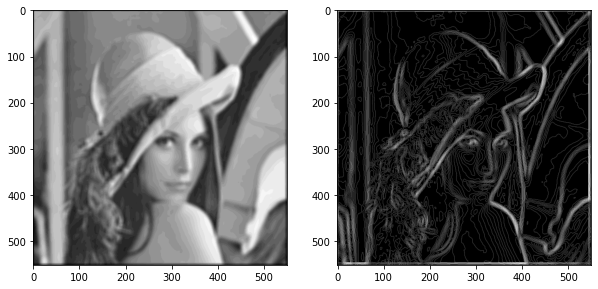

In [7]:
grad_roberts, angle= roberts_filters(filtered_img)
affiche(filtered_img, grad_roberts)

### 1.2 - Opérateur de Prewitt et de Sobel

Le calcul de gradient de ces 2 opérateurs est mené par l'intermédiaire de deux masques, le premier effectuant un gradient
horizontal, le second un gradient vertical.
Ces masques ont l'avantage de produire deux effets. Outre le calcul du gradient dans une direction, ces
masques effectuent un lissage dans la direction orthogonale. Ce lissage rend ces masques un peu moins
sensibles au bruit que le filtre de Roberts.

#### 1.2.1 - Prewitt


$$ h_1 = 1/3 \begin{pmatrix}
-1 & 0 & 1\\
-1 & 0 & 1\\
-1 & 0 & 1\\
\end{pmatrix}$$


$$ h_2 = 1/3 \begin{pmatrix}
-1 & -1 & -1\\
0 & 0 & 0\\
1 & 1 & 1\\
\end{pmatrix}$$

In [8]:
def prewitt_filters(image) :
    Kx = (1/3)*np.array([[-1,0,1],[-1,0,1],[-1,0,1]]) #On normalise par 1/3
    Ky = (1/3)*np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
    
    Ix = convolve(image, Kx)
    Iy = convolve(image, Ky)
    
    Gradient = np.sqrt(Ix**2 + Iy**2)
    theta = np.arctan2(Iy, Ix)
    
    return Gradient, theta

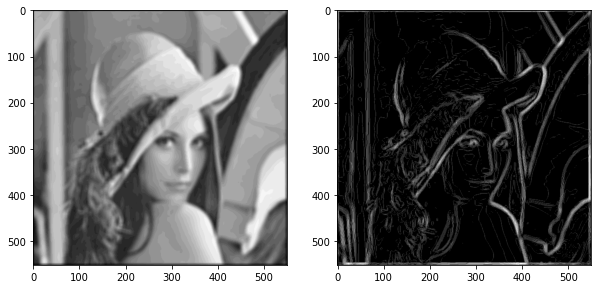

In [9]:
grad_prewitt, angle= prewitt_filters(filtered_img)
affiche(filtered_img, grad_prewitt)

#### 1.2.2 - Sobel
$$ h_1 = 1/4 \begin{pmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1\\
\end{pmatrix}$$


$$ h_2 = 1/4 \begin{pmatrix}
1 & 2 & 1\\
0 & 0 & 0\\
-1 & -2 & -1\\
\end{pmatrix}$$

In [10]:
def sobel_filters(image):
    Kx = (1/4)*np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

    Ky = (1/4)*np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    
    Ix = convolve(image, Kx)
    Iy = convolve(image, Ky)

    
    G = np.hypot(Ix, Iy) #fonction qui calcule la norme euclidienne
    #G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return Ix, Iy, G, theta

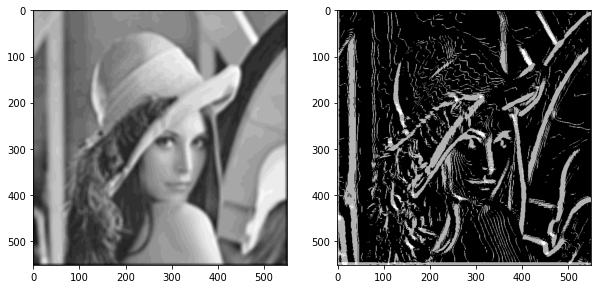

In [11]:
_, y, grad_sobel, angle= sobel_filters(filtered_img)
affiche(filtered_img, grad_sobel)

Il existe bien sûr beaucoup d'autres masques utilisés pour déterminer le gradient d'une image.
On utilisera par la suite le filtre de Sobel par son efficacité.

### 2 - Filtre de Canny
Le filtre de Canny est un algorithme de détection de contour développé par John Canny en 1986. C'est la méthode la plus utilisée et précise dans la détection de contours, elle est basée sur le calcul du gradient avec un filtre de Sobel.Canny a proposé un filtre déterminé analytiquement à partir de 3
critères :


1 - garantir une bonne détection, c’est-à-dire une réponse forte même à de faibles contours


2 - garantir une bonne localisation


3 - assurer que pour un contour il n’y aura qu’une seule détection (éviter les effets de rebonds dus par exemple,à la troncature des filtres)

Ce filtre est réalisé en 4 étapes + l'étape 0 qu'on a déja vu précédemment : le filtre gaussien

#### 2.1 -  STEP 1 : Calcul du gradient avec le filtre de Sobel 
Comme on l'a également vu précédemment, le gradient de l'image filtrée se calcule par une convolution avec un filtre de Sobel, qui est le plus efficace

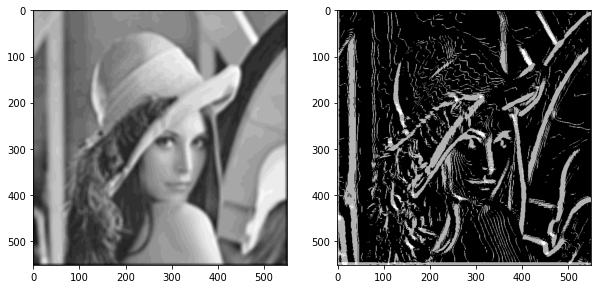

In [12]:
_, _, grad_sobel, angle= sobel_filters(filtered_img)
affiche(filtered_img, grad_sobel)

#### 2.2 -  STEP 2 : Suppression des non-maximaux 
L'interet de cette étape est de supprimer les contours redondants identifiés par le filtre de Sobel, en gardant seulement les pixels qui ont une intensité maximale le long de la direction du gradient. 

Un pixel peut avoir un total de 4 directions pour le gradient car il existe un total de 8 pixels voisins (voisinage de Moore).

Pour chaque pixel, on commence par vérifier son orientation. Ensuite, on va voir si ce pixel est plus intense que son voisin dans la direction de son gradient. Si c'est le cas, nous comparons le pixel avec son voisin dans la direction opposée. Si ce pixel a une intensité maximale par rapport à ses voisins dans les deux directions, alors c'est un maximum local. Ce pixel sera conservé. Dans tous les autres cas, ce n'est pas un maximum local et le pixel est supprimé.

In [13]:
def non_max_delete(image, theta):
    M, N = image.shape
    new = np.zeros((M,N), dtype=np.int32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
                q = 255
                r = 255

                #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = image[i, j+1]
                    r = image[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = image[i+1, j-1]
                    r = image[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = image[i+1, j]
                    r = image[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = image[i-1, j-1]
                    r = image[i+1, j+1]

                if (image[i,j] >= q) and (image[i,j] >= r):
                    new[i,j] = image[i,j]
                else:
                    new[i,j] = 0
    return new

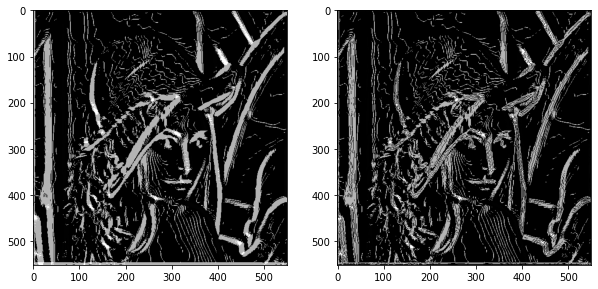

In [14]:
step2 = non_max_delete(grad_sobel, angle)
affiche(grad_sobel, step2)

#### 2.3 -  STEP 3 : Seuillage
L'idée principale de cette étape est de prendre tous les contours et de les définir comme étant soit faibles, soit forts. Nous définissons un seuil haut, au-dessus duquel les gradients sont considérés comme des contours forts. Tous les pixels dont le gradient dépasse ce seuil sont marqués comme des contours forts et sont généralement représentés en blanc (255). De même, nous définissons un seuil bas, en dessous duquel les gradients sont considérés comme des contours faibles. Ils sont conservés mais représentés avec une valeur plus faible (25), pour les distinguer des contours forts. 

In [15]:
def double_threshold(image, lowThresholdRatio=0.3, highThresholdRatio=0.7):
    
    norm_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    highThreshold = norm_image.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = image.shape
    new = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(norm_image >= highThreshold)
    zeros_i, zeros_j = np.where(norm_image < lowThreshold)
    
    weak_i, weak_j = np.where((norm_image <= highThreshold) & (norm_image >= lowThreshold))
    
    new[strong_i, strong_j] = strong
    new[weak_i, weak_j] = weak
    
    return new, weak, strong

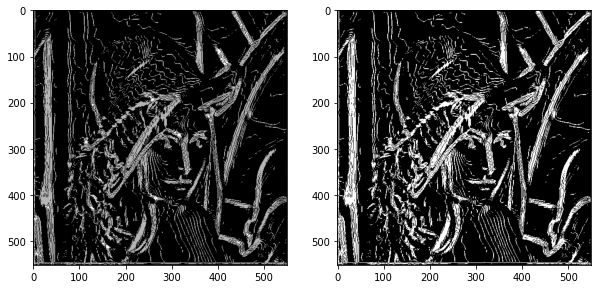

In [16]:
step3, weak, strong = double_threshold(step2, lowThresholdRatio=0.3, highThresholdRatio=0.7)
affiche(step2, step3)

#### 2.4 -  STEP 4: Seuillage par Hysteresis

Dans cette dernière étape, les pixels de contour faible qui sont connectés à des pixels de contour fort sont également considérés comme des contours forts. Cela permet de former des contours complets.

In [17]:
def hysteresis(image, weak, strong):
    M, N = image.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (image[i,j] == weak):
                if ((image[i+1, j-1] == strong) or (image[i+1, j] == strong) or (image[i+1, j+1] == strong)
                    or (image[i, j-1] == strong) or (image[i, j+1] == strong)
                    or (image[i-1, j-1] == strong) or (image[i-1, j] == strong) or (image[i-1, j+1] == strong)):
                    image[i, j] = strong
                else:
                    image[i, j] = 0

    return image

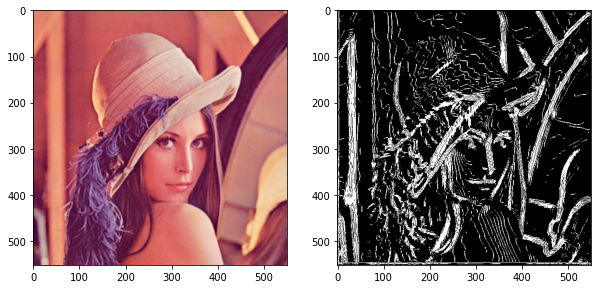

In [18]:
step4 = hysteresis(step3, weak, strong)
affiche(image, step4)

### 3 -  Filtrage par le filtre Laplacien
Les opérateurs de gradient vus précédemment exploitent le fait qu'un contour dans une image correspond au
maximum du gradient dans la direction orthogonale au contour. Or le passage par zéro de la dérivée seconde
d'une rupture d'intensité permet également de mettre en évidence le contour. 
$\newline$La dérivée seconde est
déterminée par le calcul du Laplacien qui peut être appliquée à une image par l'intermédiaire d'un filtrage
avec un masque $3*3$ donné ci-dessous

Le Laplacien d'une image $I$ est le vecteur $$\nabla^2 I(x,y) $$défini par : 

$$\nabla^2 I(x,y) = (\frac{\delta^2{I(x,y)}}{\delta^2{x}}, \frac{\delta^2{I(x,y)}}{\delta^2{y}} ) ^t$$

In [19]:
def laplacian_filters(image,num_filters) :
    if num_filters == 1:
        filter = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    
    elif num_filters == 2:
        filter = np.array([[-1, -1, -1], [-1, -8, -1], [-1, -1, -1]])
        
    elif num_filters == 3:
        filter = np.array([[1, -2, 1], [-2, 4, -2], [1, -2, 1]])
        
    laplacian = convolve(image,filter)
    
    return laplacian

Les étapes pour la détection de contour est le même que pour le gradient, sauf que l'on n'a plus l'étape de suppression des non maximuns.
$\newline$
Il n'est d'ailleurs pas nécessaire de détecter spécifiquement les zéros car Le laplacien est calculé en appliquant un filtre qui met en évidence les variations d'intensité des pixels dans l'image. Les zones de forte variation d'intensité, qui indiquent généralement des contours, sont détectées à partir des valeurs positives et négatives résultantes du calcul du laplacien et du seuillage.

In [20]:
# Prétraitement avec un filtre gaussien
filtered_img = gaussian_kernel(image_niveau_gris, 10,10)

# Calcul du Laplacien 
laplacian = laplacian_filters(filtered_img,1)

# Seuillage par Hysteresis
new, weak, strong = double_threshold(laplacian, lowThresholdRatio=0.3, highThresholdRatio=0.7)
image_seuil = hysteresis(new, weak, strong)

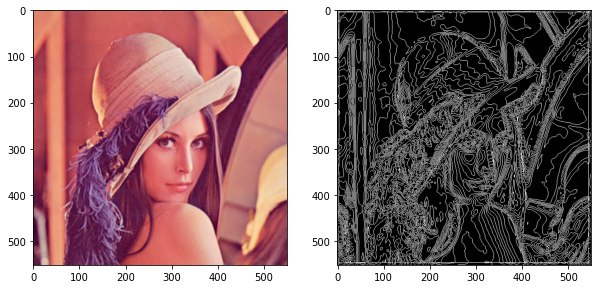

In [21]:
affiche(image,image_seuil)

### 4 -  Transformée de Hough 
Le filtre de Canny est souvent utilisé comme étape préliminaire pour détecter les contours, tandis que la transformée de Hough est une technique complémentaire utilisée pour extraire des formes spécifiques (lignes, cercles) à partir des contours détectés.

La transformée de Hough repose sur le principe de représentation des formes géométriques dans un espace de paramètres appelé espace de Hough. L'idée est de convertir chaque point de l'image qui appartient à une certaine forme géométrique en un ensemble de paramètres qui décrivent cette forme dans l'espace de Hough. 

Si deux points de contour se trouvent sur la même forme géométrique de l'image, leurs courbes sinusoïdales correspondantes s'intersecteront à une paire spécifique de paramètres dans l'espace de Hough. Ainsi, l'algorithme de transformation de Hough détecte les formes géométriques en recherchant les paires de paramètres qui ont un nombre d'intersections supérieur à un certain seuil.

Une fois que toutes les formes sont détectées dans l'espace de Hough, elles peuvent être récupérées en inversant la transformation de Hough. Cela implique de parcourir les points d'intersection dans l'espace de Hough et de les convertir en coordonnées d'image correspondantes.

Nous allons implémenter dans ce notebook seulement la transformée de Hough sur les lignes. D'autres transformée de Hough existent pour d'autres formes géométriques.

Toute ligne  est modélisé par l'équation en coordonnées polaire d'une droite : $\rho = xcos(\theta) + ysin(\theta)$.

Les limites de l'espace de Hough ont été représentées. Le point 0 est en bas à gauche de l'image. Les deux paramètres sont bornés. Si on note Nx et Ny les nombres de pixels horizontalement et verticalement, les domaines sont :
$\newline$
- $\rho \in [0, \sqrt{N_x^2 + N_y^2}]$
- $\theta \in [0^\circ, 180^\circ]$

La méthode de Hough repose sur l'utilisation d'une matrice accumulateur qui correspond à une discrétisation de ce domaine. 
Initialement, l'accumulateur est vide.

In [22]:
from math import sqrt

def calculate_rho_theta_range(edge_image_width, edge_image_height):
    d = sqrt(edge_image_width**2 + edge_image_height**2)
    rho_range = np.arange(-d, d,1)
    theta_range = np.arange(0,180,1)

    return rho_range, theta_range

def create_accumulator(num_rhos, num_thetas):
    accumulator = np.zeros((num_rhos, num_thetas))
    return accumulator

Pour chaque pixel M(x,y) de l'image, on incrémente dans l'accumulateur d'une unité les points de la courbe d'équation $\rho = xcos(\theta) + ysin(\theta)$.
En fonction des indices (i,j) des pixels (l'indice j correspond à la ligne), l'équation est :

- $\rho = i \cos(\theta) + (N_y - j) \sin(\theta)$

Lorsque tous les points de l'image ont été traités, on sélectionne les éléments de l'accumulateur remplis au dessus d'un certain seuil, qui sont alors interprétés comme les paramètres de droites correspondant à des lignes sur l'image.

Le seuil est utilisé pour contrôler la sensibilité de la détection de lignes. Si on définit un seuil élevé, seules les lignes avec une forte accumulation seront détectées, ce qui peut conduire à une détection plus précise mais avec moins de lignes détectées. À l'inverse, si on définit un seuil plus bas, on peut détecter un plus grand nombre de lignes, mais cela peut également inclure des détections moins fiables ou du bruit.

In [23]:
import matplotlib.lines as mlines

# Entrée : 
#   edge_image, sortie d'un algorithme de détection de contours (ici Canny)
#   num_rhos, nombre de valeurs discrètes pour le paramètre ρ dans l'espace de Hough
#   num_thetas, nombre de valeurs discrètes ou de compartiments pour le paramètre θ
#   threshold, le seuil requis pour qu'une paire (ρ, θ) soit considérée comme une ligne

def hough_transform(edge_image, num_rhos = 180, num_thetas = 180, threshold = 3):
    Nx, Ny = edge_image.shape
    rho_range, theta_range = calculate_rho_theta_range(Nx,Ny)
    accumulator = create_accumulator(num_rhos,num_thetas)
    diagonal_length = sqrt(Nx**2 + Ny**2)
    
    # On itère sur tous les pixels de edge_image
    for y in range(Nx):
        for x in range(Ny):
            if edge_image[y, x] > 0:  # Vérification de si le pixel est un pixel contour
                for theta_index in range(num_thetas):
                    # On calcule la valeur de ρ correspondant pour le θ actuel
                    theta = np.deg2rad(theta_index / num_thetas * 180.0)
                    rho = x * np.cos(theta) + y * np.sin(theta)
                    rho_index = int((rho + diagonal_length) / (2 * diagonal_length) * num_rhos)
                    
                    # On incrémente l'accumulateur pour les indices de θ et de ρ correspondant
                    accumulator[rho_index, theta_index] += 1
                    
                    
                    
    figure = plt.figure(figsize=(12, 12))
    subplot1 = figure.add_subplot(1, 2, 1)
    subplot1.set_facecolor((0, 0, 0))
    subplot2 = figure.add_subplot(1, 2, 2)
    subplot2.imshow(edge_image)

    for y in range(accumulator.shape[0]):
        for x in range(accumulator.shape[1]):
              if accumulator[y][x] > threshold :
                    rho = rho_range[y]
                    theta = theta_range[x]
                    a = np.cos(np.deg2rad(theta))
                    b = np.sin(np.deg2rad(theta))

                    # Coordonnées d'un point (x0, y0) sur la ligne détéctée
                    x0 = (a * rho) + Nx/2
                    y0 = (b * rho) + Ny/2

                    # Coordonnées d'un autre point (x1, y1) sur la ligne détéctée      
                    x1 = int(x0 + 1000 * (-b))
                    y1 = int(y0 + 1000 * (a))

                    # Coordonnées d'un point sur le segment de droite situé de l'autre côté 
                    # du point de départ (x0, y0) et distant de 1000 unités dans la direction perpendiculaire.

                    x2 = int(x0 - 1000 * (-b))
                    y2 = int(y0 - 1000 * (a))

                    # On trace le point sur subplot1
                    subplot1.plot([theta], [rho], marker='o', color="red")
                    # On ajoute la ligne sur subplot2
                    subplot2.add_line(mlines.Line2D([x1, x2], [y1, y2], color = "red"))
    
    subplot1.invert_yaxis()
    subplot1.invert_xaxis()

  
    subplot1.title.set_text("Espace de Hough")
    subplot2.title.set_text("Lignes détectées")
    plt.show()

/home/smussard/.conda/envs/mysepteo/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


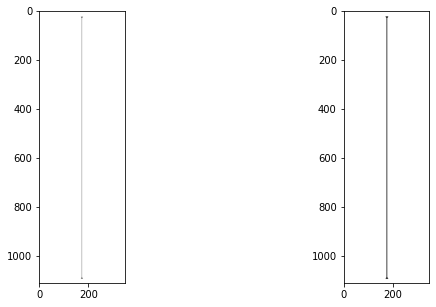

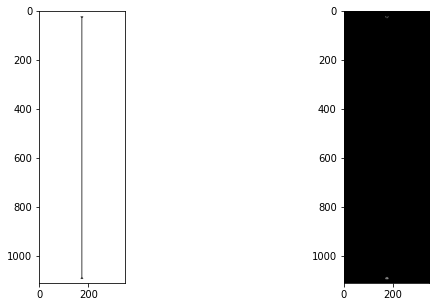

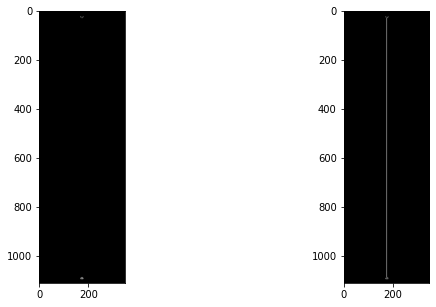

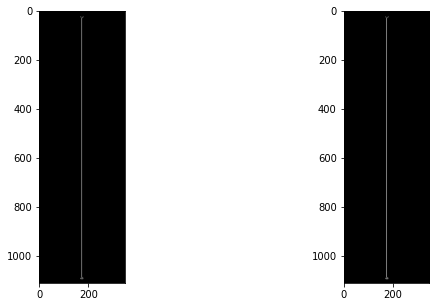

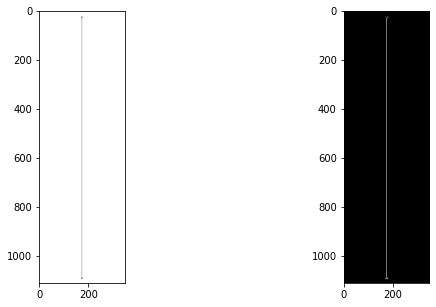

In [25]:
# Test
current_path = os.getcwd()
image_test = Image.open(current_path+'/trait.png')
image_niveau_gris_test = image_test.convert('L')
affiche(image_test, image_niveau_gris_test)
_, image2_test, grad, angle= sobel_filters(image_niveau_gris_test)
affiche(image_niveau_gris_test, image2_test)
image3_test = non_max_delete(grad, angle)
affiche(image2_test, image3_test)
new_test,_,_ = double_threshold(image3_test, lowThresholdRatio=0.3, highThresholdRatio=0.7)
affiche(image3_test,new_test)
image4_test = hysteresis(new_test, weak=25, strong=255)
affiche(image_test,image4_test)

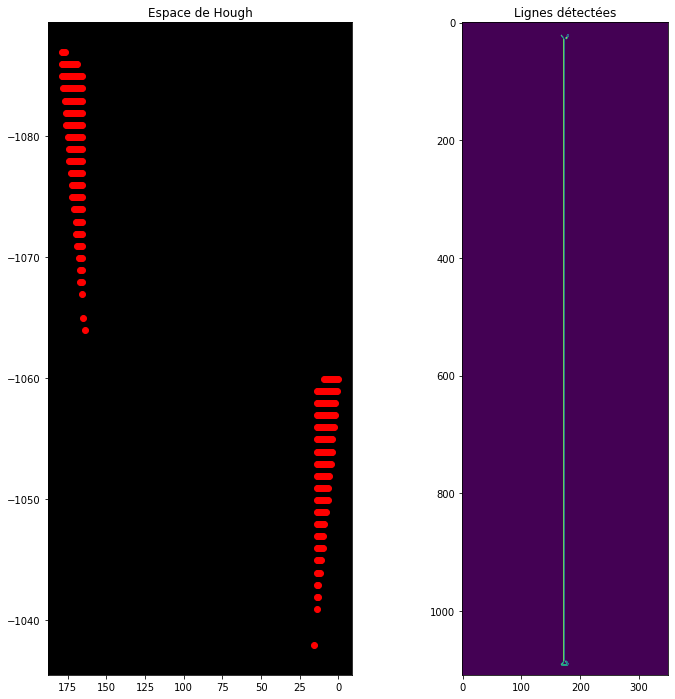

In [26]:
hough_transform(image4_test, threshold = 100)

# II- Détection de contours avec des méthodes de Deep Learning et Machine Learning

### 2.1 Méthodes de Machine Learning

Dans cette partie, nous allons essayer de prédire les contours d'une image en utilisant des algorithmes de Random Forest. \
Le jeu de données utilisé contient des images des rues de Barcelone. Ces images sont préalablement découpées et regroupées dans un dossier d'entraînement, accompagnées de leurs étiquettes respectives. Un autre dossier contient les images de test, également accompagnées de leurs étiquettes. \
Les étiquettes sont des images où les pixels sont marqués avec un 1 s'ils font partie d'un contour, et avec un 0 sinon.

L'algorithme de Random Forest est une méthode d'apprentissage automatique utilisée pour la classification et/ou la régression. Il fonctionne en créant un ensemble d'arbres de décision, où chaque arbre est construit de manière aléatoire. L'algorithme combine ensuite les prédictions de tous les arbres pour prendre une décision finale.

##### Random Forest Classifier

Puisque nos labels sont de type binaire, nous allons utiliser un algorithme de Random Forest Classifier, permettant de classifier les pixels de l'image (1 pour un contour et 0 sinon). 

In [ ]:
import numpy as np
%matplotlib inline
import cv2, os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Import du dataset
current_path = os.getcwd()

DATADIR = current_path + "/BIPED/edges/imgs"
PATH = current_path + "/BIPED/edges/edge_maps"
path1 = os.path.join(DATADIR,"train/rgbr/real")
path2 = os.path.join(DATADIR,"test/rgbr/real")
path3 = os.path.join(PATH,"train/rgbr/real")
path4 = os.path.join(PATH,"test/rgbr/real")
X_train = []
X_test = []
y_train = []
y_test = []

new_shape=(500, 500)

for img in os.listdir(path1):  # iterate over each image by converting the scale
    img_array1 = cv2.imread(os.path.join(path1,img), cv2.IMREAD_GRAYSCALE)# cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array1, new_shape)  
    resized_img = (resized_img >= 1).astype(int)
    X_train.append(resized_img)
for img in os.listdir(path2):  # iterate over each image
    img_array2 = cv2.imread(os.path.join(path2,img), cv2.IMREAD_GRAYSCALE) # cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array2, new_shape)  
    resized_img = (resized_img >= 1).astype(int)
    X_test.append(resized_img)

for img in os.listdir(path3):  # iterate over each image
    img_array3 = cv2.imread(os.path.join(path3,img), cv2.IMREAD_GRAYSCALE) # cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array3, new_shape)  
    resized_img = (resized_img >= 1).astype(int)
    y_train.append(resized_img)
for img in os.listdir(path4):  # iterate over each image 
    img_array4 = cv2.imread(os.path.join(path4,img), cv2.IMREAD_GRAYSCALE) #,cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array4, new_shape)  
    resized_img = (resized_img >= 1).astype(int)
    y_test.append(resized_img)
    
# Mise sous forme np.array du dataset
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


On importe le dataset les mettant sous la forme souhaitée. \
Les pixels ayant une valeur de 1 sont considérés comme des contours, tandis que ceux ayant une valeur de 0 sont considérés comme n'étant pas des contours.

In [ ]:
# Redimension des données en une seule dimension 
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

On redimensionne les données sur une seule dimension pour pouvoir appliquer l'agorithme de Random Forest

In [ ]:
# Tri des images en fonction du nombre de pixels à 1 (en fonction du nombre de contours dans l'image)
pixels_a_1 = np.count_nonzero(y_train == 1, axis=1)
indices_tries = np.argsort(pixels_a_1)
y_train = y_train[indices_tries]
X_train = X_train[indices_tries]

On trie les images pour qu'on donne à l'algorithme le plus de contours possible et qu'il soit le plus performant possible.

<font color="red">**Attention :** Ne pas exécuter la cellule Python suivante !</font> 

Cette cellule contient un code qui nécessite une longue durée d'exécution (environ 60 à 100 minutes).

In [ ]:
# Entraînement du modèle
rf_classifier = RandomForestClassifier(n_estimators=20, random_state=42)
rf_classifier.fit(X_train, y_train)

In [ ]:
# Prédiction des contours pour les données de test
y_pred = rf_classifier.predict(X_test)

# Évaluation des performances du modèle
accuracy = np.mean(y_pred == y_test)
print("Précision du modèle :", accuracy)

La précision du modèle sur les données de test est très bonne, ce qui nous conforte dans le choix de notre type de Random Forest.

In [ ]:
# Prédiction des contours pour les données d'entrainement
y_pred = rf_classifier.predict(X_train)

# Évaluation des performances du modèle sur les données d'entrainement
accuracy = np.mean(y_pred == y_train)
print("Précision du modèle sur les données d'entrainement :", accuracy)

La précision du modèle est également excellente sur les données d'entrainement, ce qui est encourageant.

In [ ]:
image_index = 15

# Réorganiser l'image prédite pour correspondre à la forme originale
predicted_image = y_pred[image_index].reshape(500, 500)

# Afficher l'image prédite
plt.imshow(predicted_image)
plt.title("Image prédite")
plt.show()

# Réorganiser l'image prédite pour correspondre à la forme originale
test_image = y_test[image_index].reshape(500, 500)

# Afficher l'image prédite
plt.imshow(test_image)
plt.title("Image de base")
plt.show()



Néanmoins, afficher les images montre que l'algorithme semble ne pas très bien trouver les contours. \
L'algorithme semble trop prendre en compte les données d'entrainement sans jamais prendre en compte les données de test, ce qui s'apparente à du surapprentissage. Il se pourrait également que le dataset présente trop de pixels sans contours.

##### Random Forest Classifier avec un nombre différent d'arbres

Dans cette partie, nous allons essayer de comprendre si le fait que l'algorithme semble faire du surapprentissage vient du nombre d'arbres utilisés dans la forêt ou non.

In [ ]:
import numpy as np
%matplotlib inline
import cv2, os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Import du dataset
current_path = os.getcwd()

DATADIR = current_path + "/BIPED/BIPED/edges/imgs"
PATH = current_path + "/BIPED/BIPED/edges/edge_maps"
path1 = os.path.join(DATADIR,"train/rgbr/real")
path2 = os.path.join(DATADIR,"test/rgbr/real")
path3 = os.path.join(PATH,"train/rgbr/real")
path4 = os.path.join(PATH,"test/rgbr/real")
X_train = []
X_test = []
y_train = []
y_test = []

new_shape=(500, 500)

for img in os.listdir(path1):  # iterate over each image by converting the scale
    img_array1 = cv2.imread(os.path.join(path1,img), cv2.IMREAD_GRAYSCALE)#,cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array1, new_shape)  
    resized_img = (resized_img >= 1).astype(int)
    X_train.append(resized_img)
for img in os.listdir(path2):  # iterate over each image
    img_array2 = cv2.imread(os.path.join(path2,img), cv2.IMREAD_GRAYSCALE) #,cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array2, new_shape)  
    resized_img = (resized_img >= 1).astype(int)
    X_test.append(resized_img)

for img in os.listdir(path3):  # iterate over each image
    img_array3 = cv2.imread(os.path.join(path3,img), cv2.IMREAD_GRAYSCALE) #,cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array3, new_shape)  
    resized_img = (resized_img >= 1).astype(int)
    y_train.append(resized_img)
for img in os.listdir(path4):  # iterate over each image 
    img_array4 = cv2.imread(os.path.join(path4,img), cv2.IMREAD_GRAYSCALE) #,cv2.IMREAD_GRAYSCALE)  # convert to array
    #img_array4.resize(200,200)
    #y_test.append(np.array(cv2.resize(img_array4, new_shape, fx = 0.1, fy=0.1)))
    resized_img = cv2.resize(img_array4, new_shape)  
    resized_img = (resized_img >= 1).astype(int)
    y_test.append(resized_img)
    

# Mise sous forme np.array du dataset
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

On importe le dataset les mettant sous la forme souhaitée. \
Les pixels ayant une valeur de 1 sont considérés comme des contours, tandis que ceux ayant une valeur de 0 sont considérés comme n'étant pas des contours.

In [ ]:
# Redimension des données en une seule dimension 
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

On redimensionne les données sur une seule dimension pour pouvoir appliquer l'agorithme de Random Forest

In [ ]:
# Tri des images en fonction du nombre de pixels à 1 (en fonction du nombre de contours dans l'image)
pixels_a_1 = np.count_nonzero(y_train == 1, axis=1)
indices_tries = np.argsort(pixels_a_1)
y_train = y_train[indices_tries]
X_train = X_train[indices_tries]

On trie les images pour qu'on donne à l'algorithme le plus de contours possible et qu'il soit le plus performant possible.

Ici, on va essayer de comprendre ce que change le nombre d'arbres dans le Random Forest pour être certains qu'on n'est pas en suraprentissage.

<font color="red">**Attention :** Ne pas exécuter les cellules Python suivantes !</font> 

Cette cellule contient un code qui nécessite une longue durée d'exécution (environ 60 à 100 minutes).

In [ ]:
forest=[]
for i in range(1,15,2):
    # Entraînement du modèle
    rf_classifier = RandomForestClassifier(n_estimators=i, random_state=42)
    rf_classifier.fit(X_train[190:199,:], y_train[190:199])
    forest.append(rf_classifier)

In [ ]:
predictions = []
accuracies=[]
for i in range(1,15,2):
    # Prédiction des contours pour les données de test
    y_pred = rf_classifier.predict(X_test)
    predictions.append(y_pred)

    # Évaluation des performances du modèle
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)

In [ ]:
plt.plot(accuracies*2)
plt.xlabel("Nombre d'arbres dans le Random Forest")
plt.ylabel("Accuracy sur les données de test")
plt.title("Accuracy du modèle en fonction du nombre d'arbres dans le Random Forest")
plt.show()

L'accuracy semble excellente pour n'importe quel nombre d'arbres dans la forêt ce qui est une assez bonne chose. \
Néanmoins, le fait que le nombre d'arbres ne fasse pas varier l'accuracy du modèle n'est pas très bon signe. \
Vérifions ça en visualisant les images prédictes en fonction du nombre d'arbres dans le modèle.

In [ ]:
image_index = 10

# Affichage des images en fonction du nombre d'arbres 
# A droite les images de base et à gauche la prédiction des différents modèles
fig, axes = plt.subplots(len(predictions), 2, figsize=(30, 30))

for i, ax in enumerate(axes.flat):
    if i % 2 == 0 :
        ax.imshow(y_test[image_index].reshape(500, 500))
    else :
        ax.imshow(predictions[i//2][image_index].reshape(500, 500))

plt.show()

En effet, en visualisant les prédictions des différents modèles (les prédictions sont à droite), il semble qu'ils prédisent à peu de choses près la même chose pour une même image.

Nous pouvons alors penser que nous sommes en sousapprentissage mais le temps d'exécution des algorithmes sur nos machines ne nous permet pas d'augmenter de façon significative le nombre d'arbres dans le modèle.

#### Random Forest Regressor

Le random forest regressor nous permet de faire de la régression et pouvoir avoir une prédiction moins stricte/qui peut trouver les contours faibles de l'image si les contours forts ne sont pas détectés. \
Cette approche paraît en théorie meilleure que la précédente car plus adaptée à notre problème de détection de contours mais voyons ce qu'il en est en pratique.

In [ ]:
import numpy as np
%matplotlib inline
import cv2, os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Import du dataset
current_path = os.getcwd()

DATADIR = current_path + "/BIPED/BIPED/edges/imgs"
PATH = current_path + "/BIPED/BIPED/edges/edge_maps"
path1 = os.path.join(DATADIR,"train/rgbr/real")
path2 = os.path.join(DATADIR,"test/rgbr/real")
path3 = os.path.join(PATH,"train/rgbr/real")
path4 = os.path.join(PATH,"test/rgbr/real")
X_train = []
X_test = []
y_train = []
y_test = []

new_shape=(100, 100)

for img in os.listdir(path1):  # iterate over each image by converting the scale
    img_array1 = cv2.imread(os.path.join(path1,img), cv2.IMREAD_GRAYSCALE)#,cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array1, new_shape)  
    X_train.append(resized_img)
for img in os.listdir(path2):  # iterate over each image
    img_array2 = cv2.imread(os.path.join(path2,img), cv2.IMREAD_GRAYSCALE) #,cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array2, new_shape)  
    X_test.append(resized_img)

for img in os.listdir(path3):  # iterate over each image
    img_array3 = cv2.imread(os.path.join(path3,img), cv2.IMREAD_GRAYSCALE) #,cv2.IMREAD_GRAYSCALE)  # convert to array
    resized_img = cv2.resize(img_array3, new_shape)  
    y_train.append(resized_img)
for img in os.listdir(path4):  # iterate over each image 
    img_array4 = cv2.imread(os.path.join(path4,img), cv2.IMREAD_GRAYSCALE) #,cv2.IMREAD_GRAYSCALE)  # convert to array
    #img_array4.resize(200,200)
    #y_test.append(np.array(cv2.resize(img_array4, new_shape, fx = 0.1, fy=0.1)))
    resized_img = cv2.resize(img_array4, new_shape)  
    y_test.append(resized_img)
    

# Mise sous forme np.array du dataset
X_train = np.array(X_train, dtype = int)/255
X_test = np.array(X_test, dtype = int)/255
y_train = np.array(y_train, dtype = int)/255
y_test = np.array(y_test, dtype = int)/255

On importe le dataset les mettant sous la forme souhaitée. \
Ici, les pixels ayant une valeur différente de 0 sont considérés comme des contours, tandis que ceux ayant une valeur de 0 sont considérés comme n'étant pas des contours.

In [ ]:
# Redimension des données en une seule dimension 
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

On redimensionne les données sur une seule dimension pour pouvoir appliquer l'agorithme de Random Forest

In [ ]:
# Tri des images en fonction du nombre de pixels à 1 (en fonction du nombre de contours dans l'image)
pixels_a_1 = np.count_nonzero(y_train == 1, axis=1)
indices_tries = np.argsort(pixels_a_1)
y_train = y_train[indices_tries]
X_train = X_train[indices_tries]

On trie les images pour qu'on donne à l'algorithme le plus de contours possible et qu'il soit le plus performant possible.

In [ ]:
# On enlève toutes les images sans contours (s'il y en a)
masque = np.any(y_train != 0, axis=1)
X_train = X_train[masque]
y_train = y_train[masque]

Il est possible que lors de la redimension des données, aucun contour ne reste dans cette méthode. On enlève donc les images sans contours.

Cette cellule contient un code qui nécessite une longue durée d'exécution (environ 60 à 100 minutes). \
Vous pouvez cependant lancer la cellule en enlevant des images d'entrainement pour l'entrainement du modèle.

In [ ]:
# Entraînement du modèle
rf_classifier = RandomForestRegressor(n_estimators=50, random_state=42)

# Si vous voulez run la cellule, commentez cette ligne et décommentez la ligne suivante
rf_classifier.fit(X_train[150:199,:], y_train[150:199])
# rf_classifier.fit(X_train[190:199,:], y_train[190:199])

In [ ]:
# Prédiction des contours pour les données d'entrainement
y_pred = rf_classifier.predict(X_test)

# Seuillage des prédictions
y_pred = y_pred>=0.1

# Évaluation des performances du modèle sur les données d'entrainement
accuracy = np.mean(y_pred == y_test)
print("Précision du modèle :", accuracy)

On entraine le modèle, on seuil les données pour avoir des binaires en sortie et on regarde la précision sur les images de test. \
Ici, on trouve une précision de 87%, ce qui est encourageant.

In [ ]:
image_index = 20

# Réorganiser l'image prédite pour correspondre à la forme originale
predicted_image = y_pred[image_index].reshape(100, 100)

# Afficher l'image prédite
plt.imshow(predicted_image)
plt.title("Image prédite")
plt.show()

# Réorganiser l'image prédite pour correspondre à la forme originale
test_image = y_test[image_index].reshape(100, 100)

# Afficher l'image prédite
plt.imshow(test_image)
plt.title("Image de base")
plt.show()



La visualisation des images nous montre que l'algorithme prédit plutôt bien les images. Cependant, il faudrait avoir un de meilleurs labels pour en être certain car ici, le fait de vouloir avoir une régression et non une classification ne nous permet pas de charger les données comme auparavant, d'où le problème avec les labels.

##### Conclusion

Pour conclure, nous pouvons dire que les résultats de cette partie sont encourageants mais les algorithme prennent beaucoup de temps à s'entrainer pour des résultats bien moins bons que pour les méthodes classiques. \
Cependant, certaines études ont révélé qu'il est envisageable de détecter des contours à l'aide d'algorithmes de Random Forest. Pour ce faire, la méthode la plus efficace consiste à créer une forêt comprenant autant d'arbres que de pixels dans l'image. Chaque arbre est entraîné et utilisé pour prédire la valeur d'un pixel spécifique dans l'image. \
Néanmoins, cette méthode n'a pas pu être appliquée ici car prenant beaucoup trop de temps à tourner (on est à environ 100min pour 20 arbres et il faudrait un minimum de 2500 arbres).

### 2.2  Méthodes de Deep Learning

Dans cette partie, nous avons décidé d'explorer la détection de contours avec d'autres méthodes du milieu du Deep Learning. Dans un premier temps, vous trouverez une partie consacrée à l'étude de la détection de contours grâce à un réseau de neurones CNN (dont l'architecture à été inventée). Vous pourrez soit refaire la phase d'apprentissage avec la phase de test soit faire uniquement la phase de test avec les poids préalablement calculés.

Dans un deuxième temps, vous aurez la possibilité d'utiliser une méthode de transfer learning (plus précisemment du fine tuning) pour réaliser de la détection de contours.

In [28]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms
import cv2, os
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as tvf

### 2.2.1 Détection de contours avec une architecture de CNN inventée

##### 1. Importation du dataset en s'insipirant du github : https://github.com/xavysp/DexiNed/blob/master/datasets.py 

Transformation de chaque image du dataset en tenseur (en héritant de la classe Dataset)

Différentes transformations : 
* Transformation des images en tenseur avec le première dimension qui correspond aux canaux RGB (ici on ne sélectionne qu'un seul canal pour avoir des images en niveau de gris).
* Transformation des tenseurs en taille 200*200 pour avoir des images de même taille.
* Normalisation des tenseurs pour avoir des valeurs de pixels entre 0 et 1. 

In [29]:
class BipedDataset(Dataset):
    train_modes = ['train', 'test', ]
    dataset_types = ['rgbr', ]
    data_types = ['real', ]

    def __init__(self,
                 data_root,
                 img_height,
                 img_width,
                 train_mode='train',
                 dataset_type='rgbr',
                 #  is_scaling=None,
                 # Whether to crop image or otherwise resize image to match image height and width.
                 crop_img=False,
                 arg=None
                 ):
        self.data_root = data_root
        self.train_mode = train_mode
        self.dataset_type = dataset_type
        self.data_type = 'real'
        self.img_height = img_height
        self.img_width = img_width
        self.crop_img = crop_img

        self.data_index = self._build_index()

    def _build_index(self):
        assert self.train_mode in self.train_modes, self.train_mode
        assert self.dataset_type in self.dataset_types, self.dataset_type
        assert self.data_type in self.data_types, self.data_type

        sample_indices = []

        images_path = os.path.join(self.data_root,
                                   'edges/imgs',
                                   self.train_mode,
                                   self.dataset_type)
        labels_path = os.path.join(self.data_root,
                                   'edges/edge_maps',
                                   self.train_mode,
                                   self.dataset_type)

        for directory_name in os.listdir(images_path):
            image_directories = os.path.join(images_path, directory_name)
            for file_name_ext in os.listdir(image_directories):
                file_name = os.path.splitext(file_name_ext)[0]
                sample_indices.append(
                    (os.path.join(images_path, directory_name, file_name + '.jpg'),
                     os.path.join(labels_path, directory_name, file_name + '.png'),)
                )

        return sample_indices

    def __len__(self):
        return len(self.data_index)

    def __getitem__(self, idx):
        #On sélectionne nos data
        image_path, label_path = self.data_index[idx]
        
        #On lit les images 
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        
        #On transforme ces images en tenseur
        image = torchvision.transforms.ToTensor()(image)
        label = torchvision.transforms.ToTensor()(label)

        #On transforme toutes nos images avec la même taille
        image = torchvision.transforms.Resize((200,200))(image)
        label = torchvision.transforms.Resize((200,200))(label)
        
        #On normalise les images entre 0 et 1
        image = (image - torch.min(image)) / (torch.max(image) - torch.min(image))
        label = (label - torch.min(label)) / (torch.max(label) - torch.min(label))

        #On sélectionne la première bande car on veut prédire un masque avec une seule bande 
        image = image[0:1,:,:]
        
        return dict(images=image, labels=label)

Transformation des images en dataloader (empilement de 8 tenseurs sur la 1ère dimension) on a donc des objets de taille (8,1,200,200)

In [30]:
current_path = os.getcwd()

train_dataset = BipedDataset(current_path+"/BIPED/BIPED",
                                     img_width=720,
                                     img_height=1280,
                                     train_mode='train',
                                     )
test_dataset = BipedDataset(current_path+"/BIPED/BIPED",
                                     img_width=720,
                                     img_height=1280,
                                     train_mode='test',
                                     )
#Transformation des images du dataset BIPED en Dataloader (empilement d'images de taille (8, 1, 200, 200))
trainloader = DataLoader(train_dataset, batch_size=8, num_workers=1)
testloader = DataLoader(test_dataset, batch_size=1, num_workers=1)

#### 2. Création de l'architecture du CNN

Définition de l'architecture du réseau de neurones en héritant de la classe torch.nn.Module. On définit une architecture autoencodeur  (l'encodeur construit de nouvelles représentations dites “encodées”. Le décodeur reçoit ces représentations et les traitent afin d’essayer de reconstruire les données de départ.)

In [31]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Partie encodeur constituée de 3 couches de convolutions (avec du zéro padding pour garder la taille de l'image de base)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
        )

        # Partie décodeur composée de 3 couches de déconvolution
        self.decodeur = nn.Sequential(

            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1),

        )
        #Classifieur sigmoid pour transformer la sortie en probabilité pour faire un seuillage et savoir si le pixel est un contour ou non
        self.classifier = nn.Sigmoid()
        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decodeur(x)
        x = self.classifier(x)
        return x

#### 3. Utilistion du GPU ou du CPU sur votre machine

ATTENTION : la prochaine cellule permet de choisir entre l'utilisation de CPU ou de GPU sur votre machine. Si vous possédez du GPU celui-ci sera utilisé, sinon on utilisera le CPU.

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Autoencoder()
net.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decodeur): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Sigmoid()
)

4. Phase d'entraînement

La prochaine cellule est à exécuter uniquement si vous souhaitez faire la phase d'entraînement de 0.

In [42]:
current_path = os.getcwd()
net.train()
optimizer = torch.optim.SGD(params = net.parameters(),lr=0.1, momentum=0.9) # Optimiseur
criterion = nn.BCELoss() #Fonction Loss
num_epochs =150
for epoch in range(num_epochs): #On réalise 150 epochs
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-------------')
    epoch_loss = 0.0
    epoch_corrects = 0
    loss_values = []
    for _, data in enumerate(tqdm(trainloader)): #On parcourt les données train
        net.to(device) #On ajoute le modèle et les données sur CPU/GPU
        img, label = data['images'].to(device), data['labels'].to(device)
        optimizer.zero_grad()
        outputs = net(img) #Les images train sont données en entrée du réseau
        loss_ =  criterion(outputs, label) # On calcule la loss
        loss_.backward() # backpropagation
        optimizer.step()
        output = (outputs>0.1).float() #Si la valeur du pixel est supérieur au seuil alors c'est un contour (1) sinon (0)
        acc = (output.cpu().detach().numpy() == label.cpu().detach().numpy()).mean()
   
    epoch_loss += loss_
    print('Epoch {} Loss : {}'.format((epoch+1),epoch_loss))
    print('Epoch {} Accuracy : {}'.format((epoch+1),acc))
torch.save(net.state_dict(), current_path + "/weights.pt")


Epoch 1/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.76it/s]


Epoch 1 Loss : 0.1317010223865509
Epoch 1 Accuracy : 0.937834375
Epoch 2/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.02it/s]


Epoch 2 Loss : 0.13203182816505432
Epoch 2 Accuracy : 0.937859375
Epoch 3/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.05it/s]


Epoch 3 Loss : 0.13249291479587555
Epoch 3 Accuracy : 0.937884375
Epoch 4/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.91it/s]


Epoch 4 Loss : 0.13249067962169647
Epoch 4 Accuracy : 0.937884375
Epoch 5/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.07it/s]


Epoch 5 Loss : 0.1316012591123581
Epoch 5 Accuracy : 0.937884375
Epoch 6/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 6 Loss : 0.13089030981063843
Epoch 6 Accuracy : 0.937884375
Epoch 7/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.13it/s]


Epoch 7 Loss : 0.1287807673215866
Epoch 7 Accuracy : 0.937903125
Epoch 8/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.16it/s]


Epoch 8 Loss : 0.1273825615644455
Epoch 8 Accuracy : 0.93745
Epoch 9/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.11it/s]


Epoch 9 Loss : 0.125926211476326
Epoch 9 Accuracy : 0.937934375
Epoch 10/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.15it/s]


Epoch 10 Loss : 0.12325765937566757
Epoch 10 Accuracy : 0.9335625
Epoch 11/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.01it/s]


Epoch 11 Loss : 0.12889550626277924
Epoch 11 Accuracy : 0.937871875
Epoch 12/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.16it/s]


Epoch 12 Loss : 0.12748505175113678
Epoch 12 Accuracy : 0.93784375
Epoch 13/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 13 Loss : 0.1288527101278305
Epoch 13 Accuracy : 0.937915625
Epoch 14/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 14 Loss : 0.13051971793174744
Epoch 14 Accuracy : 0.937934375
Epoch 15/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.11it/s]


Epoch 15 Loss : 0.12783633172512054
Epoch 15 Accuracy : 0.937934375
Epoch 16/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.14it/s]


Epoch 16 Loss : 0.13092541694641113
Epoch 16 Accuracy : 0.937934375
Epoch 17/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch 17 Loss : 0.1272285431623459
Epoch 17 Accuracy : 0.937925
Epoch 18/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 18 Loss : 0.12368348985910416
Epoch 18 Accuracy : 0.93114375
Epoch 19/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch 19 Loss : 0.12685126066207886
Epoch 19 Accuracy : 0.937534375
Epoch 20/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.13it/s]


Epoch 20 Loss : 0.12068237364292145
Epoch 20 Accuracy : 0.92051875
Epoch 21/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.19it/s]


Epoch 21 Loss : 0.11990272998809814
Epoch 21 Accuracy : 0.925540625
Epoch 22/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 22 Loss : 0.11751919984817505
Epoch 22 Accuracy : 0.9152875
Epoch 23/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 23 Loss : 0.11710050702095032
Epoch 23 Accuracy : 0.9122125
Epoch 24/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch 24 Loss : 0.1172015368938446
Epoch 24 Accuracy : 0.918521875
Epoch 25/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.13it/s]


Epoch 25 Loss : 0.1147073358297348
Epoch 25 Accuracy : 0.910490625
Epoch 26/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 26 Loss : 0.1146349310874939
Epoch 26 Accuracy : 0.91133125
Epoch 27/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch 27 Loss : 0.11314882338047028
Epoch 27 Accuracy : 0.907440625
Epoch 28/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 28 Loss : 0.11308183521032333
Epoch 28 Accuracy : 0.91523125
Epoch 29/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.06it/s]


Epoch 29 Loss : 0.11240702867507935
Epoch 29 Accuracy : 0.91215625
Epoch 30/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 30 Loss : 0.11201242357492447
Epoch 30 Accuracy : 0.90001875
Epoch 31/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.13it/s]


Epoch 31 Loss : 0.11151652783155441
Epoch 31 Accuracy : 0.91126875
Epoch 32/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.13it/s]


Epoch 32 Loss : 0.1109367161989212
Epoch 32 Accuracy : 0.90178125
Epoch 33/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 33 Loss : 0.11085382848978043
Epoch 33 Accuracy : 0.907803125
Epoch 34/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 34 Loss : 0.11049411445856094
Epoch 34 Accuracy : 0.90073125
Epoch 35/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.17it/s]


Epoch 35 Loss : 0.11017440259456635
Epoch 35 Accuracy : 0.9013875
Epoch 36/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 36 Loss : 0.1100459173321724
Epoch 36 Accuracy : 0.902
Epoch 37/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.13it/s]


Epoch 37 Loss : 0.11002880334854126
Epoch 37 Accuracy : 0.897421875
Epoch 38/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.13it/s]


Epoch 38 Loss : 0.10972974449396133
Epoch 38 Accuracy : 0.89825625
Epoch 39/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch 39 Loss : 0.10964660346508026
Epoch 39 Accuracy : 0.895409375
Epoch 40/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.06it/s]


Epoch 40 Loss : 0.1094953864812851
Epoch 40 Accuracy : 0.894628125
Epoch 41/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 41 Loss : 0.10936808586120605
Epoch 41 Accuracy : 0.894078125
Epoch 42/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch 42 Loss : 0.10926933586597443
Epoch 42 Accuracy : 0.8920625
Epoch 43/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.14it/s]


Epoch 43 Loss : 0.10914453119039536
Epoch 43 Accuracy : 0.89244375
Epoch 44/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 44 Loss : 0.10905686020851135
Epoch 44 Accuracy : 0.890171875
Epoch 45/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.05it/s]


Epoch 45 Loss : 0.10894772410392761
Epoch 45 Accuracy : 0.890059375
Epoch 46/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.91it/s]


Epoch 46 Loss : 0.10886574536561966
Epoch 46 Accuracy : 0.88818125
Epoch 47/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 47 Loss : 0.10877778381109238
Epoch 47 Accuracy : 0.887634375
Epoch 48/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.06it/s]


Epoch 48 Loss : 0.10870621353387833
Epoch 48 Accuracy : 0.886265625
Epoch 49/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.01it/s]


Epoch 49 Loss : 0.10866905003786087
Epoch 49 Accuracy : 0.88495
Epoch 50/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.05it/s]


Epoch 50 Loss : 0.10860104858875275
Epoch 50 Accuracy : 0.8838
Epoch 51/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch 51 Loss : 0.10869748145341873
Epoch 51 Accuracy : 0.8821375
Epoch 52/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 52 Loss : 0.10859879851341248
Epoch 52 Accuracy : 0.881221875
Epoch 53/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.05it/s]


Epoch 53 Loss : 0.10909149795770645
Epoch 53 Accuracy : 0.87725
Epoch 54/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch 54 Loss : 0.10872846096754074
Epoch 54 Accuracy : 0.876921875
Epoch 55/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.07it/s]


Epoch 55 Loss : 0.10933087766170502
Epoch 55 Accuracy : 0.875671875
Epoch 56/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 56 Loss : 0.10842037945985794
Epoch 56 Accuracy : 0.876578125
Epoch 57/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 57 Loss : 0.10866118967533112
Epoch 57 Accuracy : 0.876921875
Epoch 58/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 58 Loss : 0.10860976576805115
Epoch 58 Accuracy : 0.872353125
Epoch 59/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 59 Loss : 0.10834186524152756
Epoch 59 Accuracy : 0.874296875
Epoch 60/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.96it/s]


Epoch 60 Loss : 0.10806059092283249
Epoch 60 Accuracy : 0.875653125
Epoch 61/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 61 Loss : 0.10796289145946503
Epoch 61 Accuracy : 0.875965625
Epoch 62/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch 62 Loss : 0.10788803547620773
Epoch 62 Accuracy : 0.875540625
Epoch 63/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.11it/s]


Epoch 63 Loss : 0.10768844932317734
Epoch 63 Accuracy : 0.877028125
Epoch 64/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.16it/s]


Epoch 64 Loss : 0.10771634429693222
Epoch 64 Accuracy : 0.8751375
Epoch 65/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 65 Loss : 0.10749173164367676
Epoch 65 Accuracy : 0.877
Epoch 66/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 66 Loss : 0.10748560726642609
Epoch 66 Accuracy : 0.875696875
Epoch 67/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 67 Loss : 0.10728765279054642
Epoch 67 Accuracy : 0.87711875
Epoch 68/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.06it/s]


Epoch 68 Loss : 0.10726911574602127
Epoch 68 Accuracy : 0.876165625
Epoch 69/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 69 Loss : 0.10710951685905457
Epoch 69 Accuracy : 0.87734375
Epoch 70/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.05it/s]


Epoch 70 Loss : 0.10706234723329544
Epoch 70 Accuracy : 0.87636875
Epoch 71/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 71 Loss : 0.10698224604129791
Epoch 71 Accuracy : 0.876865625
Epoch 72/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 72 Loss : 0.10687620937824249
Epoch 72 Accuracy : 0.87670625
Epoch 73/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch 73 Loss : 0.10678913444280624
Epoch 73 Accuracy : 0.87709375
Epoch 74/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 74 Loss : 0.10669052600860596
Epoch 74 Accuracy : 0.876825
Epoch 75/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 75 Loss : 0.10661984235048294
Epoch 75 Accuracy : 0.876734375
Epoch 76/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch 76 Loss : 0.1065375953912735
Epoch 76 Accuracy : 0.876784375
Epoch 77/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.04it/s]


Epoch 77 Loss : 0.10645440220832825
Epoch 77 Accuracy : 0.87689375
Epoch 78/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 78 Loss : 0.10636558383703232
Epoch 78 Accuracy : 0.8768875
Epoch 79/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 79 Loss : 0.10629560053348541
Epoch 79 Accuracy : 0.876778125
Epoch 80/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 80 Loss : 0.10621996968984604
Epoch 80 Accuracy : 0.876865625
Epoch 81/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.05it/s]


Epoch 81 Loss : 0.10615119338035583
Epoch 81 Accuracy : 0.87675
Epoch 82/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 82 Loss : 0.10608675330877304
Epoch 82 Accuracy : 0.8766875
Epoch 83/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.13it/s]


Epoch 83 Loss : 0.10601067543029785
Epoch 83 Accuracy : 0.876853125
Epoch 84/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 84 Loss : 0.10594074428081512
Epoch 84 Accuracy : 0.876890625
Epoch 85/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.05it/s]


Epoch 85 Loss : 0.10587317496538162
Epoch 85 Accuracy : 0.876846875
Epoch 86/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 86 Loss : 0.10581108182668686
Epoch 86 Accuracy : 0.87689375
Epoch 87/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.06it/s]


Epoch 87 Loss : 0.10573830455541611
Epoch 87 Accuracy : 0.87681875
Epoch 88/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.07it/s]


Epoch 88 Loss : 0.10569920390844345
Epoch 88 Accuracy : 0.876790625
Epoch 89/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.11it/s]


Epoch 89 Loss : 0.10563907027244568
Epoch 89 Accuracy : 0.87671875
Epoch 90/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.11it/s]


Epoch 90 Loss : 0.10559462755918503
Epoch 90 Accuracy : 0.876859375
Epoch 91/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 91 Loss : 0.10553248971700668
Epoch 91 Accuracy : 0.876896875
Epoch 92/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.11it/s]


Epoch 92 Loss : 0.10549072176218033
Epoch 92 Accuracy : 0.876871875
Epoch 93/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 93 Loss : 0.10543655604124069
Epoch 93 Accuracy : 0.87693125
Epoch 94/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch 94 Loss : 0.10541483759880066
Epoch 94 Accuracy : 0.8768625
Epoch 95/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.14it/s]


Epoch 95 Loss : 0.1053437739610672
Epoch 95 Accuracy : 0.876878125
Epoch 96/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch 96 Loss : 0.10531651228666306
Epoch 96 Accuracy : 0.8769125
Epoch 97/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 97 Loss : 0.1052561104297638
Epoch 97 Accuracy : 0.8769625
Epoch 98/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 98 Loss : 0.10522700101137161
Epoch 98 Accuracy : 0.8770625
Epoch 99/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.11it/s]


Epoch 99 Loss : 0.10516579449176788
Epoch 99 Accuracy : 0.877090625
Epoch 100/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.07it/s]


Epoch 100 Loss : 0.10514166951179504
Epoch 100 Accuracy : 0.877028125
Epoch 101/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.07it/s]


Epoch 101 Loss : 0.10507111251354218
Epoch 101 Accuracy : 0.877234375
Epoch 102/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.11it/s]


Epoch 102 Loss : 0.10504460334777832
Epoch 102 Accuracy : 0.8773375
Epoch 103/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.05it/s]


Epoch 103 Loss : 0.1049700677394867
Epoch 103 Accuracy : 0.8776
Epoch 104/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 104 Loss : 0.10494077205657959
Epoch 104 Accuracy : 0.8777125
Epoch 105/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch 105 Loss : 0.10486991703510284
Epoch 105 Accuracy : 0.87790625
Epoch 106/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.13it/s]


Epoch 106 Loss : 0.10482802242040634
Epoch 106 Accuracy : 0.878209375
Epoch 107/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.03it/s]


Epoch 107 Loss : 0.10477583110332489
Epoch 107 Accuracy : 0.878234375
Epoch 108/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch 108 Loss : 0.10473379492759705
Epoch 108 Accuracy : 0.87851875
Epoch 109/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 109 Loss : 0.10468988865613937
Epoch 109 Accuracy : 0.878596875
Epoch 110/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.11it/s]


Epoch 110 Loss : 0.10465246438980103
Epoch 110 Accuracy : 0.87851875
Epoch 111/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 111 Loss : 0.10460200905799866
Epoch 111 Accuracy : 0.878715625
Epoch 112/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.13it/s]


Epoch 112 Loss : 0.10456232726573944
Epoch 112 Accuracy : 0.87875
Epoch 113/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 113 Loss : 0.10452204197645187
Epoch 113 Accuracy : 0.878915625
Epoch 114/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.11it/s]


Epoch 114 Loss : 0.10449124127626419
Epoch 114 Accuracy : 0.87883125
Epoch 115/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.07it/s]


Epoch 115 Loss : 0.10445369780063629
Epoch 115 Accuracy : 0.878865625
Epoch 116/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.11it/s]


Epoch 116 Loss : 0.10442345589399338
Epoch 116 Accuracy : 0.8789
Epoch 117/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.11it/s]


Epoch 117 Loss : 0.10438809543848038
Epoch 117 Accuracy : 0.879040625
Epoch 118/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.11it/s]


Epoch 118 Loss : 0.1043475940823555
Epoch 118 Accuracy : 0.87905625
Epoch 119/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 119 Loss : 0.10430463403463364
Epoch 119 Accuracy : 0.8791125
Epoch 120/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch 120 Loss : 0.10423185676336288
Epoch 120 Accuracy : 0.879740625
Epoch 121/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 121 Loss : 0.10418336093425751
Epoch 121 Accuracy : 0.87989375
Epoch 122/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.16it/s]


Epoch 122 Loss : 0.10414610058069229
Epoch 122 Accuracy : 0.879959375
Epoch 123/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 123 Loss : 0.10409431159496307
Epoch 123 Accuracy : 0.880275
Epoch 124/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 124 Loss : 0.10405220836400986
Epoch 124 Accuracy : 0.880378125
Epoch 125/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 125 Loss : 0.10400474816560745
Epoch 125 Accuracy : 0.88065
Epoch 126/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.13it/s]


Epoch 126 Loss : 0.1039578840136528
Epoch 126 Accuracy : 0.88066875
Epoch 127/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 127 Loss : 0.10391329973936081
Epoch 127 Accuracy : 0.881071875
Epoch 128/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 128 Loss : 0.10387759655714035
Epoch 128 Accuracy : 0.8810625
Epoch 129/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 129 Loss : 0.10383623093366623
Epoch 129 Accuracy : 0.881253125
Epoch 130/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.95it/s]


Epoch 130 Loss : 0.10379625856876373
Epoch 130 Accuracy : 0.88141875
Epoch 131/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.07it/s]


Epoch 131 Loss : 0.10374905914068222
Epoch 131 Accuracy : 0.881675
Epoch 132/150
-------------


100%|██████████| 25/25 [00:05<00:00,  5.00it/s]


Epoch 132 Loss : 0.10371164232492447
Epoch 132 Accuracy : 0.881846875
Epoch 133/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 133 Loss : 0.1036667674779892
Epoch 133 Accuracy : 0.88201875
Epoch 134/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 134 Loss : 0.1036398634314537
Epoch 134 Accuracy : 0.882203125
Epoch 135/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 135 Loss : 0.10360616445541382
Epoch 135 Accuracy : 0.882225
Epoch 136/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 136 Loss : 0.10356834530830383
Epoch 136 Accuracy : 0.8824375
Epoch 137/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.08it/s]


Epoch 137 Loss : 0.10352843999862671
Epoch 137 Accuracy : 0.88261875
Epoch 138/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.10it/s]


Epoch 138 Loss : 0.10349006950855255
Epoch 138 Accuracy : 0.88295
Epoch 139/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.06it/s]


Epoch 139 Loss : 0.10345667600631714
Epoch 139 Accuracy : 0.88308125
Epoch 140/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch 140 Loss : 0.10343537479639053
Epoch 140 Accuracy : 0.882965625
Epoch 141/150
-------------


100%|██████████| 25/25 [00:05<00:00,  5.00it/s]


Epoch 141 Loss : 0.1034095287322998
Epoch 141 Accuracy : 0.88308125
Epoch 142/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.03it/s]


Epoch 142 Loss : 0.10338593274354935
Epoch 142 Accuracy : 0.883078125
Epoch 143/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.07it/s]


Epoch 143 Loss : 0.10336357355117798
Epoch 143 Accuracy : 0.88300625
Epoch 144/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.05it/s]


Epoch 144 Loss : 0.10333622992038727
Epoch 144 Accuracy : 0.883071875
Epoch 145/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.98it/s]


Epoch 145 Loss : 0.10332145541906357
Epoch 145 Accuracy : 0.88276875
Epoch 146/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]


Epoch 146 Loss : 0.10328906029462814
Epoch 146 Accuracy : 0.882965625
Epoch 147/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.97it/s]


Epoch 147 Loss : 0.10327509790658951
Epoch 147 Accuracy : 0.882678125
Epoch 148/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.09it/s]


Epoch 148 Loss : 0.10324463993310928
Epoch 148 Accuracy : 0.882734375
Epoch 149/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.11it/s]


Epoch 149 Loss : 0.10322768241167068
Epoch 149 Accuracy : 0.882596875
Epoch 150/150
-------------


100%|██████████| 25/25 [00:04<00:00,  5.12it/s]

Epoch 150 Loss : 0.10320474952459335
Epoch 150 Accuracy : 0.882646875


#### 5. Phase de test 

In [33]:
current_path = os.getcwd()
path = current_path + "/weights.pt"
net.load_state_dict(torch.load(path, map_location=device))
criterion = nn.BCELoss()
with torch.no_grad():
    correct = 0
    total = 0
    loss_test =0
    net.eval()
    for _,data in enumerate(testloader):
        image, label = data['images'].to(device), data['labels'].to(device)
        outputs = net(image)
        loss = criterion(outputs, label)
        loss_test+=loss.item()
        output = (outputs>0.1).float()
        acc = (output.cpu().detach().numpy() == label.cpu().detach().numpy()).mean()
        
    test_loss=loss_test/len(test_dataset)
    print('Loss : {}'.format(test_loss))
    print('Accuracy : {}'.format(acc))

Loss : 0.11152099151164294
Accuracy : 0.902225


#### 6. Visualisation des feature maps

Dans cette partie nous visualisons les feature maps. Nous nous sommes inspirés du lien suivant : https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573. 
Ce sont les résultats obtenus entre la convolution d'un filtre (qui est appris par le réseau de neurones) et l'image d'entrée.

On re-crée l'architecture sans le nn.Sequentiel car on a besoin d'appeler chaque couche les unes après les autres pour pouvoir identifier les couches de convolution et déconvolution

In [34]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encodeur1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.encodeur2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.encodeur3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.decodeur1 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.decodeur2 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.decodeur3 = nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1)
        self.classifier = nn.Sigmoid()
        

    def forward(self, x):
        x = self.encodeur1(x)
        x = self.relu1(x)
        x = self.encodeur2(x)
        x = self.relu2(x)
        x = self.encodeur3(x)
        x = self.decodeur1(x)
        x = self.relu3(x)
        x = self.decodeur2(x)
        x = self.relu4(x)
        x = self.decodeur3(x)
        x = self.classifier(x)
        
        return x

Dans le code suivant vous devez mettre le chemin correspondant à l'emplacement du fichier weights_feature_maps.pt dans votre ordinateur

In [35]:
model = Autoencoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#On charge les poids de ce réseau préalablement entraîné  
current_path = os.getcwd()
path = current_path+ "/weights_feature_maps.pt"
model.load_state_dict(torch.load(path, map_location=device))

<All keys matched successfully>

In [36]:
model_weights =[]
conv_layers = []
model_children = list(model.children())
counter = 0
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d or type(model_children[i]) == nn.ConvTranspose2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 6
conv_layers


In [37]:
import cv2
current_path = os.getcwd()
lena = cv2.imread(current_path + "/lena.png",  cv2.IMREAD_COLOR )
lena = torchvision.transforms.ToTensor()(lena)
lena = lena[0:1, :,:]

In [38]:
out = []
names = []
for layer in conv_layers[0:]:
    lena = layer(lena)
    out.append(lena)
    names.append(str(layer))

In [39]:
processed = []
for feature_map in out:
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())


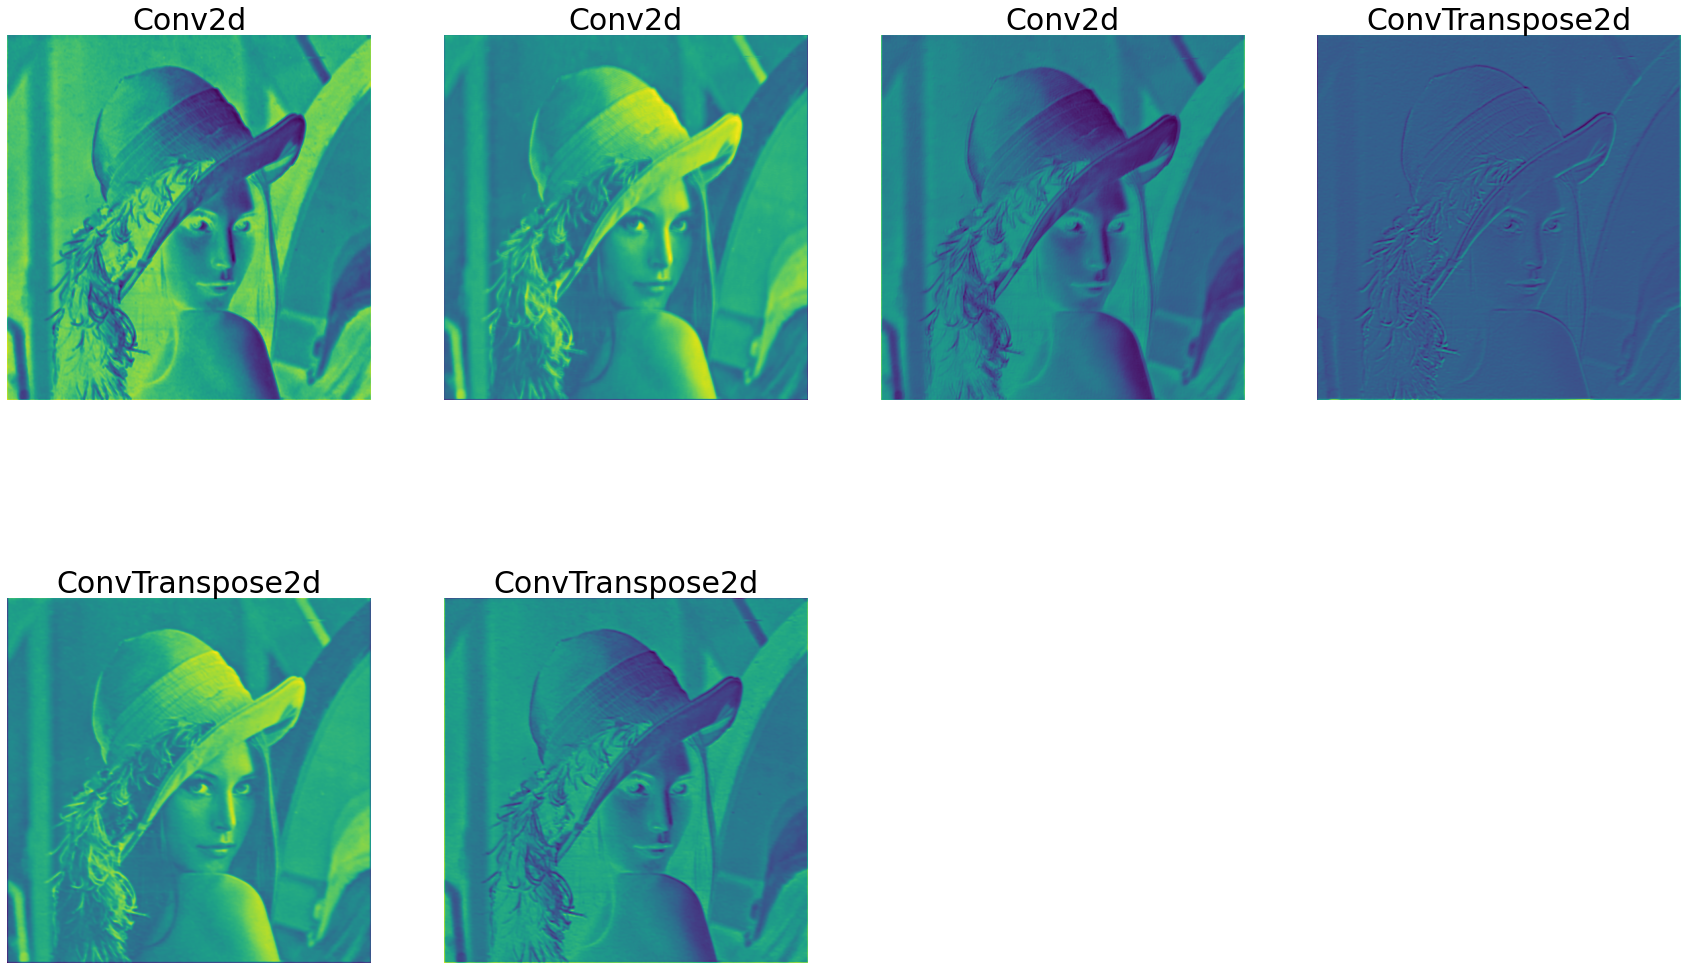

In [40]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)

On voit donc que la troisième couche commence à capter les contours de l'image

#### 7. Affichage des contours sur des images

Affichage des contours sur une image du dataset

In [41]:
outputs = output.cpu()

On change l'emplacement des dimensions pour avoir les canaux RGB sur la 3ème dimension

In [42]:
outputs = outputs.detach().numpy()
outputs = outputs[0,:,:,:]
outputs = np.swapaxes(outputs, 0, 1)
outputs= np.swapaxes(outputs, 1,2)

On seuille la prédiction du réseau pour obtenir les contours

In [43]:
threshold = 0.10
y_pred = (outputs > threshold) # 0.0 or 1.0

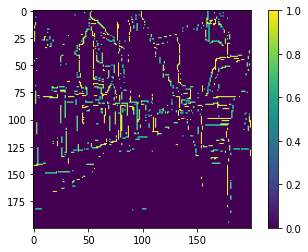

In [44]:
plt.imshow(y_pred)
plt.colorbar()

Comparaison avec le label 

In [45]:
labels = label.cpu().detach().numpy()
labels = labels[0,:,:,:]
labels = np.swapaxes(labels, 0, 1)
labels= np.swapaxes(labels, 1,2)

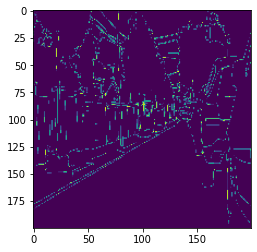

In [46]:
plt.imshow(labels)

Affichage des contours sur une image qui n'est pas du dataset


In [47]:
current_path = os.getcwd()
lena = cv2.imread(current_path+"/lena.png",  cv2.IMREAD_COLOR )

On transforme l'image en tenseur Pytorch pour qu'elle puisse passer dans le réseau

In [48]:
lena = torchvision.transforms.ToTensor()(lena)

On passe l'image dans le réseau

In [49]:
outputs = net(lena[0:1, :,:].to(device))

On change les dimensions pour avoir les canaux RGB sur la 3ème dimension

In [50]:
labels = outputs.cpu().detach().numpy()
labels = np.swapaxes(labels, 0, 1)
labels= np.swapaxes(labels, 1,2)

On seuille la prédiction pour obtenir les contours

In [51]:
threshold = 0.05
y_pred = (labels > threshold)

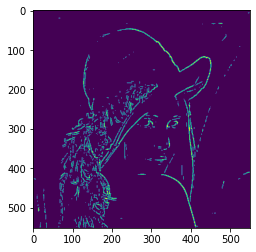

In [52]:
plt.imshow(y_pred)

### 2.2.2 Détection de contours avec une architecture de CNN inventée

Dans cette partie nous réalisons du fine tuning. Cela consiste à utiliser un réseau de neurones entraîné sur une tâche différente à celle de la détection de contours et à réutiliser les poids de celui-ci pour réaliser une nouvelle phase d'apprentissage cette fois-ci spécifique à la détection de contours.

1. Chargement des données 
On refait le chargement des données (il faut que les images soient un multiple de 32)

In [53]:
class BipedDataset(Dataset):
    train_modes = ['train', 'test', ]
    dataset_types = ['rgbr', ]
    data_types = ['real', ]

    def __init__(self,
                 data_root,
                 img_height,
                 img_width,
                 train_mode='train',
                 dataset_type='rgbr',
                 #is_scaling=None,
                 crop_img=False,
                 arg=None
                 ):
        self.data_root = data_root
        self.train_mode = train_mode
        self.dataset_type = dataset_type
        self.data_type = 'real'  # be aware that this might change in the future
        self.img_height = img_height
        self.img_width = img_width
        self.crop_img = crop_img

        self.data_index = self._build_index()

    def _build_index(self):
        assert self.train_mode in self.train_modes, self.train_mode
        assert self.dataset_type in self.dataset_types, self.dataset_type
        assert self.data_type in self.data_types, self.data_type

        #data_root = os.path.abspath(self.data_root)
        sample_indices = []

        images_path = os.path.join(self.data_root,
                                   'edges/imgs',
                                   self.train_mode,
                                   self.dataset_type)
        labels_path = os.path.join(self.data_root,
                                   'edges/edge_maps',
                                   self.train_mode,
                                   self.dataset_type)

        for directory_name in os.listdir(images_path):
            image_directories = os.path.join(images_path, directory_name)
            for file_name_ext in os.listdir(image_directories):
                file_name = os.path.splitext(file_name_ext)[0]
                sample_indices.append(
                    (os.path.join(images_path, directory_name, file_name + '.jpg'),
                     os.path.join(labels_path, directory_name, file_name + '.png'),)
                )

        return sample_indices

    def __len__(self):
        return len(self.data_index)

    def __getitem__(self, idx):
        #On sélectionne nos data
        image_path, label_path = self.data_index[idx]
        
        #On lit les images 
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        
        #On transforme ces images en tenseur
        image = torchvision.transforms.ToTensor()(image)
        label = torchvision.transforms.ToTensor()(label)

        #On transforme toutes nos images avec la même taille
        image = torchvision.transforms.Resize((384,384))(image)
        label = torchvision.transforms.Resize((384,384))(label)
        
        #On normalise les images entre 0 et 1
        image = (image - torch.min(image)) / (torch.max(image) - torch.min(image))
        label = (label - torch.min(label)) / (torch.max(label) - torch.min(label))

        #On sélectionne la première bande car on veut prédire un masque avec une seule bande 
        image = image[0:1,:,:]
        
        return dict(images=image, labels=label)

In [54]:
current_path = os.getcwd()

train_dataset = BipedDataset(current_path+"/BIPED/BIPED",
                                     img_width=720,
                                     img_height=1280,
                                     train_mode='train',
                                     )
test_dataset = BipedDataset(current_path+"/BIPED/BIPED",
                                     img_width=720,
                                     img_height=1280,
                                     train_mode='test',
                                     )
#Transformation des images du dataset BIPED en Dataloader (empilement d'images de taille (8, 1, 200, 200))
trainloader = DataLoader(train_dataset, batch_size=8, num_workers=1)
testloader = DataLoader(test_dataset, batch_size=1, num_workers=1)

2. Chargment du réseau de neurones U-Net 

Ce réseau de neurones à été entraîné sur une tâche de segmentation. Ici on change juste la première couche en une couche de convolution qui prend une seule bande en entrée 

In [55]:
import torchvision.models.densenet
#On télécharge le modèle pré-entraîné
net = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)
net.encoder1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

Using cache found in /home/smussard/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


3. Utilisation du GPU/CPU

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

4. Phase d'entraînement

On réalise une phase d'entraînement du réseau Unet pour le spécialiser dans une tâche de détection de contours

In [67]:
net.train()
optimizer = torch.optim.SGD(params = net.parameters(),lr=0.1, momentum=0.9)
criterion = nn.BCELoss()
num_epochs =150
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-------------')
    epoch_loss = 0.0
    epoch_corrects = 0
    loss_values = []
    for _, data in enumerate(tqdm(trainloader)):
        net.to(device)
        img, label = data['images'].to(device), data['labels'].to(device)
        optimizer.zero_grad()
        outputs = net(img)
        loss_ =  criterion(outputs, label)
        loss_.backward()
        optimizer.step()
        output = (outputs>0.1).float()
        acc = (output.cpu().detach().numpy() == label.cpu().detach().numpy()).mean()
        
    loss_values.append(loss_ / len(trainloader))
    epoch_loss += loss_
    print('Epoch {} Loss : {}'.format((epoch+1),epoch_loss))
    print('Epoch {} Accuracy : {}'.format((epoch+1),acc))
current_path = os.getcwd()
torch.save(net.state_dict(), current_path+"weights_unet_updated.pt")

Epoch 1/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.14it/s]


Epoch 1 Loss : 0.13557648658752441
Epoch 1 Accuracy : 0.9374618530273438
Epoch 2/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 2 Loss : 0.13213033974170685
Epoch 2 Accuracy : 0.9374601576063368
Epoch 3/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 3 Loss : 0.1255325973033905
Epoch 3 Accuracy : 0.9315897623697916
Epoch 4/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 4 Loss : 0.12646222114562988
Epoch 4 Accuracy : 0.9361326429578993
Epoch 5/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 5 Loss : 0.12342527508735657
Epoch 5 Accuracy : 0.9302147759331597
Epoch 6/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 6 Loss : 0.12172765284776688
Epoch 6 Accuracy : 0.9248335096571181
Epoch 7/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.20it/s]


Epoch 7 Loss : 0.12092158943414688
Epoch 7 Accuracy : 0.9176534016927084
Epoch 8/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.21it/s]


Epoch 8 Loss : 0.11848579347133636
Epoch 8 Accuracy : 0.9070587158203125
Epoch 9/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.21it/s]


Epoch 9 Loss : 0.11805788427591324
Epoch 9 Accuracy : 0.9119449191623263
Epoch 10/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 10 Loss : 0.11435171216726303
Epoch 10 Accuracy : 0.8984103732638888
Epoch 11/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 11 Loss : 0.11420350521802902
Epoch 11 Accuracy : 0.8879123263888888
Epoch 12/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 12 Loss : 0.11152026802301407
Epoch 12 Accuracy : 0.8933469984266493
Epoch 13/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 13 Loss : 0.11196748167276382
Epoch 13 Accuracy : 0.8840654161241319
Epoch 14/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.14it/s]


Epoch 14 Loss : 0.10974331945180893
Epoch 14 Accuracy : 0.8931096394856771
Epoch 15/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.19it/s]


Epoch 15 Loss : 0.108769990503788
Epoch 15 Accuracy : 0.8784501817491319
Epoch 16/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 16 Loss : 0.1069728434085846
Epoch 16 Accuracy : 0.8848631117078993
Epoch 17/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 17 Loss : 0.10716287046670914
Epoch 17 Accuracy : 0.8997260199652778
Epoch 18/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.03it/s]


Epoch 18 Loss : 0.1053662970662117
Epoch 18 Accuracy : 0.8844095865885416
Epoch 19/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 19 Loss : 0.10306373983621597
Epoch 19 Accuracy : 0.8906606038411459
Epoch 20/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.21it/s]


Epoch 20 Loss : 0.10212026536464691
Epoch 20 Accuracy : 0.8819181654188368
Epoch 21/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.09it/s]


Epoch 21 Loss : 0.10138700902462006
Epoch 21 Accuracy : 0.8843087090386285
Epoch 22/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 22 Loss : 0.10025761276483536
Epoch 22 Accuracy : 0.8747117784288194
Epoch 23/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.17it/s]


Epoch 23 Loss : 0.09999597072601318
Epoch 23 Accuracy : 0.8745100233289931
Epoch 24/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 24 Loss : 0.09983477741479874
Epoch 24 Accuracy : 0.881866455078125
Epoch 25/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.20it/s]


Epoch 25 Loss : 0.10036011785268784
Epoch 25 Accuracy : 0.8715260823567709
Epoch 26/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 26 Loss : 0.10141005367040634
Epoch 26 Accuracy : 0.8751644558376737
Epoch 27/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.14it/s]


Epoch 27 Loss : 0.1008763462305069
Epoch 27 Accuracy : 0.8713124593098959
Epoch 28/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 28 Loss : 0.10010693222284317
Epoch 28 Accuracy : 0.8813874986436632
Epoch 29/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.14it/s]


Epoch 29 Loss : 0.09920264780521393
Epoch 29 Accuracy : 0.8715430365668403
Epoch 30/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 30 Loss : 0.09906289726495743
Epoch 30 Accuracy : 0.8828726874457465
Epoch 31/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 31 Loss : 0.09927073866128922
Epoch 31 Accuracy : 0.8835254245334201
Epoch 32/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 32 Loss : 0.09856285154819489
Epoch 32 Accuracy : 0.8802668253580729
Epoch 33/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 33 Loss : 0.09800812602043152
Epoch 33 Accuracy : 0.8780576917860243
Epoch 34/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 34 Loss : 0.09777632355690002
Epoch 34 Accuracy : 0.8788341946072049
Epoch 35/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 35 Loss : 0.09794073551893234
Epoch 35 Accuracy : 0.8761918809678819
Epoch 36/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.11it/s]


Epoch 36 Loss : 0.09658355265855789
Epoch 36 Accuracy : 0.8764131334092882
Epoch 37/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 37 Loss : 0.09668456763029099
Epoch 37 Accuracy : 0.8761656019422743
Epoch 38/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.21it/s]


Epoch 38 Loss : 0.09655030816793442
Epoch 38 Accuracy : 0.8760655721028646
Epoch 39/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.19it/s]


Epoch 39 Loss : 0.0968925878405571
Epoch 39 Accuracy : 0.8777838812934028
Epoch 40/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 40 Loss : 0.0968715250492096
Epoch 40 Accuracy : 0.8791308932834201
Epoch 41/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 41 Loss : 0.09639400243759155
Epoch 41 Accuracy : 0.8790198432074653
Epoch 42/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 42 Loss : 0.09645701944828033
Epoch 42 Accuracy : 0.8765733506944444
Epoch 43/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 43 Loss : 0.09649535268545151
Epoch 43 Accuracy : 0.8842112223307291
Epoch 44/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.14it/s]


Epoch 44 Loss : 0.09641857445240021
Epoch 44 Accuracy : 0.8846071031358507
Epoch 45/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.02it/s]


Epoch 45 Loss : 0.09552965313196182
Epoch 45 Accuracy : 0.8827701144748263
Epoch 46/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 46 Loss : 0.09561029821634293
Epoch 46 Accuracy : 0.8820665147569444
Epoch 47/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.25it/s]


Epoch 47 Loss : 0.09535321593284607
Epoch 47 Accuracy : 0.8788104587131076
Epoch 48/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.21it/s]


Epoch 48 Loss : 0.09501121938228607
Epoch 48 Accuracy : 0.8795089721679688
Epoch 49/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 49 Loss : 0.09531556069850922
Epoch 49 Accuracy : 0.8794538709852431
Epoch 50/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.20it/s]


Epoch 50 Loss : 0.09539344906806946
Epoch 50 Accuracy : 0.8775270250108507
Epoch 51/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 51 Loss : 0.0954178050160408
Epoch 51 Accuracy : 0.8755272759331597
Epoch 52/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 52 Loss : 0.09556906670331955
Epoch 52 Accuracy : 0.875152587890625
Epoch 53/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 53 Loss : 0.09543267637491226
Epoch 53 Accuracy : 0.8765343560112847
Epoch 54/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 54 Loss : 0.09552017599344254
Epoch 54 Accuracy : 0.8792215983072916
Epoch 55/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 55 Loss : 0.09551946073770523
Epoch 55 Accuracy : 0.8836491902669271
Epoch 56/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.14it/s]


Epoch 56 Loss : 0.09499064832925797
Epoch 56 Accuracy : 0.877777099609375
Epoch 57/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 57 Loss : 0.09496022760868073
Epoch 57 Accuracy : 0.8758892483181424
Epoch 58/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 58 Loss : 0.09422365576028824
Epoch 58 Accuracy : 0.8772616916232638
Epoch 59/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 59 Loss : 0.09375772625207901
Epoch 59 Accuracy : 0.8808805677625868
Epoch 60/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.13it/s]


Epoch 60 Loss : 0.09359218925237656
Epoch 60 Accuracy : 0.8818783230251737
Epoch 61/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.20it/s]


Epoch 61 Loss : 0.09371951967477798
Epoch 61 Accuracy : 0.8827489217122396
Epoch 62/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 62 Loss : 0.09380810707807541
Epoch 62 Accuracy : 0.8822733561197916
Epoch 63/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 63 Loss : 0.0939616784453392
Epoch 63 Accuracy : 0.8825564914279513
Epoch 64/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.12it/s]


Epoch 64 Loss : 0.09443262964487076
Epoch 64 Accuracy : 0.8813891940646701
Epoch 65/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 65 Loss : 0.09410885721445084
Epoch 65 Accuracy : 0.8791249593098959
Epoch 66/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 66 Loss : 0.09376831352710724
Epoch 66 Accuracy : 0.8768827650282118
Epoch 67/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.19it/s]


Epoch 67 Loss : 0.09324859082698822
Epoch 67 Accuracy : 0.8774625990125868
Epoch 68/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.13it/s]


Epoch 68 Loss : 0.0934760645031929
Epoch 68 Accuracy : 0.877059088812934
Epoch 69/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 69 Loss : 0.0935981422662735
Epoch 69 Accuracy : 0.8825124104817709
Epoch 70/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 70 Loss : 0.09323008358478546
Epoch 70 Accuracy : 0.8814476860894097
Epoch 71/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 71 Loss : 0.09308428317308426
Epoch 71 Accuracy : 0.8789800008138021
Epoch 72/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.20it/s]


Epoch 72 Loss : 0.09285175800323486
Epoch 72 Accuracy : 0.8799514770507812
Epoch 73/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.13it/s]


Epoch 73 Loss : 0.09276851266622543
Epoch 73 Accuracy : 0.881011962890625
Epoch 74/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 74 Loss : 0.09243778884410858
Epoch 74 Accuracy : 0.8806372748480903
Epoch 75/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.13it/s]


Epoch 75 Loss : 0.09240109473466873
Epoch 75 Accuracy : 0.8813069661458334
Epoch 76/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 76 Loss : 0.0923723578453064
Epoch 76 Accuracy : 0.8823835584852431
Epoch 77/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 77 Loss : 0.0923125371336937
Epoch 77 Accuracy : 0.8820682101779513
Epoch 78/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 78 Loss : 0.09218855947256088
Epoch 78 Accuracy : 0.8814612494574653
Epoch 79/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.21it/s]


Epoch 79 Loss : 0.09209220111370087
Epoch 79 Accuracy : 0.8806711832682291
Epoch 80/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 80 Loss : 0.09194473177194595
Epoch 80 Accuracy : 0.8796751234266493
Epoch 81/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 81 Loss : 0.0917656421661377
Epoch 81 Accuracy : 0.8801099989149306
Epoch 82/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 82 Loss : 0.09163424372673035
Epoch 82 Accuracy : 0.8813298543294271
Epoch 83/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 83 Loss : 0.0915936529636383
Epoch 83 Accuracy : 0.8824140760633681
Epoch 84/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 84 Loss : 0.09166859090328217
Epoch 84 Accuracy : 0.882218254937066
Epoch 85/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.14it/s]


Epoch 85 Loss : 0.09162232279777527
Epoch 85 Accuracy : 0.8819588555230035
Epoch 86/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 86 Loss : 0.09148131310939789
Epoch 86 Accuracy : 0.8818011813693576
Epoch 87/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 87 Loss : 0.09131310135126114
Epoch 87 Accuracy : 0.8807856241861979
Epoch 88/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 88 Loss : 0.09119487553834915
Epoch 88 Accuracy : 0.8779118855794271
Epoch 89/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 89 Loss : 0.09111195057630539
Epoch 89 Accuracy : 0.8761706882052951
Epoch 90/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.14it/s]


Epoch 90 Loss : 0.09097326546907425
Epoch 90 Accuracy : 0.8763224283854166
Epoch 91/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.19it/s]


Epoch 91 Loss : 0.09097862988710403
Epoch 91 Accuracy : 0.876511467827691
Epoch 92/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.11it/s]


Epoch 92 Loss : 0.09085713326931
Epoch 92 Accuracy : 0.877838134765625
Epoch 93/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 93 Loss : 0.09084563702344894
Epoch 93 Accuracy : 0.8797861735026041
Epoch 94/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.21it/s]


Epoch 94 Loss : 0.09075925499200821
Epoch 94 Accuracy : 0.8796641031901041
Epoch 95/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 95 Loss : 0.09080446511507034
Epoch 95 Accuracy : 0.8804685804578993
Epoch 96/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 96 Loss : 0.0906175971031189
Epoch 96 Accuracy : 0.8802456325954862
Epoch 97/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 97 Loss : 0.09102483838796616
Epoch 97 Accuracy : 0.8821139865451388
Epoch 98/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 98 Loss : 0.09088052809238434
Epoch 98 Accuracy : 0.8822928534613715
Epoch 99/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.22it/s]


Epoch 99 Loss : 0.09057285636663437
Epoch 99 Accuracy : 0.8776287502712674
Epoch 100/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 100 Loss : 0.09060908108949661
Epoch 100 Accuracy : 0.8784400092230903
Epoch 101/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.19it/s]


Epoch 101 Loss : 0.09093579649925232
Epoch 101 Accuracy : 0.8813018798828125
Epoch 102/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.19it/s]


Epoch 102 Loss : 0.0904250517487526
Epoch 102 Accuracy : 0.8813468085394965
Epoch 103/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.19it/s]


Epoch 103 Loss : 0.09010804444551468
Epoch 103 Accuracy : 0.8817791408962674
Epoch 104/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 104 Loss : 0.0898752212524414
Epoch 104 Accuracy : 0.8815850151909722
Epoch 105/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 105 Loss : 0.08995118737220764
Epoch 105 Accuracy : 0.8829837375217013
Epoch 106/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.11it/s]


Epoch 106 Loss : 0.0900808796286583
Epoch 106 Accuracy : 0.8841222127278646
Epoch 107/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 107 Loss : 0.0899803414940834
Epoch 107 Accuracy : 0.8833685980902778
Epoch 108/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 108 Loss : 0.09015138447284698
Epoch 108 Accuracy : 0.8844112820095487
Epoch 109/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.20it/s]


Epoch 109 Loss : 0.08996766060590744
Epoch 109 Accuracy : 0.8839857313368056
Epoch 110/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 110 Loss : 0.08963444083929062
Epoch 110 Accuracy : 0.8827845255533854
Epoch 111/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.20it/s]


Epoch 111 Loss : 0.08972165733575821
Epoch 111 Accuracy : 0.8817774454752604
Epoch 112/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.09it/s]


Epoch 112 Loss : 0.08995319902896881
Epoch 112 Accuracy : 0.8809153238932291
Epoch 113/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.19it/s]


Epoch 113 Loss : 0.08975440263748169
Epoch 113 Accuracy : 0.8792521158854166
Epoch 114/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 114 Loss : 0.08974478393793106
Epoch 114 Accuracy : 0.8767454359266493
Epoch 115/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.23it/s]


Epoch 115 Loss : 0.08999088406562805
Epoch 115 Accuracy : 0.8777525160047743
Epoch 116/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 116 Loss : 0.09007515758275986
Epoch 116 Accuracy : 0.8783348931206597
Epoch 117/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 117 Loss : 0.0893501415848732
Epoch 117 Accuracy : 0.8787350124782987
Epoch 118/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.19it/s]


Epoch 118 Loss : 0.08904803544282913
Epoch 118 Accuracy : 0.8794886271158854
Epoch 119/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.14it/s]


Epoch 119 Loss : 0.08880983293056488
Epoch 119 Accuracy : 0.8785324096679688
Epoch 120/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 120 Loss : 0.0887838751077652
Epoch 120 Accuracy : 0.8791817559136285
Epoch 121/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.20it/s]


Epoch 121 Loss : 0.08871821314096451
Epoch 121 Accuracy : 0.8793979220920138
Epoch 122/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 122 Loss : 0.08863905817270279
Epoch 122 Accuracy : 0.8788062201605903
Epoch 123/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.17it/s]


Epoch 123 Loss : 0.08869738131761551
Epoch 123 Accuracy : 0.8782942030164931
Epoch 124/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.13it/s]


Epoch 124 Loss : 0.08867620676755905
Epoch 124 Accuracy : 0.8789605034722222
Epoch 125/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.21it/s]


Epoch 125 Loss : 0.08881276845932007
Epoch 125 Accuracy : 0.8790791829427084
Epoch 126/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 126 Loss : 0.08889353275299072
Epoch 126 Accuracy : 0.8797590467664931
Epoch 127/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.19it/s]


Epoch 127 Loss : 0.08847774565219879
Epoch 127 Accuracy : 0.8788969251844618
Epoch 128/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.20it/s]


Epoch 128 Loss : 0.08898311108350754
Epoch 128 Accuracy : 0.8783654106987847
Epoch 129/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.14it/s]


Epoch 129 Loss : 0.08885550498962402
Epoch 129 Accuracy : 0.8763410780164931
Epoch 130/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.22it/s]


Epoch 130 Loss : 0.08889736235141754
Epoch 130 Accuracy : 0.8786137898763021
Epoch 131/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 131 Loss : 0.08874472230672836
Epoch 131 Accuracy : 0.8771489461263021
Epoch 132/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 132 Loss : 0.08896008878946304
Epoch 132 Accuracy : 0.8722110324435763
Epoch 133/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.14it/s]


Epoch 133 Loss : 0.0893254280090332
Epoch 133 Accuracy : 0.8746007283528646
Epoch 134/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 134 Loss : 0.08857601881027222
Epoch 134 Accuracy : 0.8750678168402778
Epoch 135/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 135 Loss : 0.08826350420713425
Epoch 135 Accuracy : 0.8798887464735243
Epoch 136/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.10it/s]


Epoch 136 Loss : 0.08863107115030289
Epoch 136 Accuracy : 0.8820215861002604
Epoch 137/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 137 Loss : 0.08816935867071152
Epoch 137 Accuracy : 0.8828854031032987
Epoch 138/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.19it/s]


Epoch 138 Loss : 0.08820807933807373
Epoch 138 Accuracy : 0.8849512736002604
Epoch 139/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.10it/s]


Epoch 139 Loss : 0.08856073021888733
Epoch 139 Accuracy : 0.8798514472113715
Epoch 140/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 140 Loss : 0.08851618319749832
Epoch 140 Accuracy : 0.8776024712456597
Epoch 141/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 141 Loss : 0.08806870132684708
Epoch 141 Accuracy : 0.8789503309461806
Epoch 142/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 142 Loss : 0.08799943327903748
Epoch 142 Accuracy : 0.8792182074652778
Epoch 143/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 143 Loss : 0.08768580853939056
Epoch 143 Accuracy : 0.8803668551974826
Epoch 144/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.19it/s]


Epoch 144 Loss : 0.08778970688581467
Epoch 144 Accuracy : 0.8777338663736979
Epoch 145/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 145 Loss : 0.0880245491862297
Epoch 145 Accuracy : 0.8783433702256944
Epoch 146/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.24it/s]


Epoch 146 Loss : 0.08799126744270325
Epoch 146 Accuracy : 0.8788257175021701
Epoch 147/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 147 Loss : 0.08813274651765823
Epoch 147 Accuracy : 0.8787765502929688
Epoch 148/150
-------------


100%|██████████| 25/25 [00:06<00:00,  4.14it/s]


Epoch 148 Loss : 0.08785530179738998
Epoch 148 Accuracy : 0.8795030381944444
Epoch 149/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 149 Loss : 0.08838200569152832
Epoch 149 Accuracy : 0.8768861558702257
Epoch 150/150
-------------


100%|██████████| 25/25 [00:05<00:00,  4.20it/s]

Epoch 150 Loss : 0.08784165978431702
Epoch 150 Accuracy : 0.8735444810655382


#### 5. Phase de test 

In [57]:
current_path = os.getcwd()
path = current_path + "/weights_unet_updated.pt"
net.load_state_dict(torch.load(path, map_location=device))
net.to(device)
criterion = nn.BCELoss()
with torch.no_grad():
    correct = 0
    total = 0
    loss_test =0
    net.eval()
    for _,data in enumerate(testloader):
        image, label = data['images'].to(device), data['labels'].to(device)
        outputs = net(image)
        loss = criterion(outputs, label)
        loss_test+=loss.item()
        output = (outputs>0.1).float()
        acc = (output.cpu().detach().numpy() == label.cpu().detach().numpy()).mean()
        
    test_loss=loss_test/len(test_dataset)
    print('Loss : {}'.format(test_loss))
    print('Accuracy : {}'.format(acc))

Loss : 0.12258004505187273
Accuracy : 0.9038289388020834


#### 6. Résultat d'une image test du dataset

In [58]:
outputs = output.cpu()

On change les dimensions pour avoir les canaux RGB sur la 3ème dimension

In [59]:
outputs = outputs.detach().numpy()
outputs = outputs[0,:,:,:]
outputs = np.swapaxes(outputs, 0, 1)
outputs= np.swapaxes(outputs, 1,2)

On seuille pour obtenir les contours

In [60]:
threshold = 0.10
y_pred = (outputs > threshold) # 0.0 or 1.0

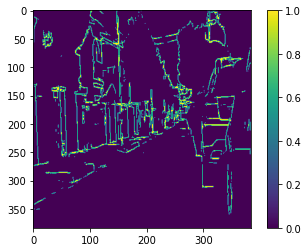

In [61]:
plt.imshow(outputs)
plt.colorbar()

#### 7. Résultat d'une image Lénna qui n'est pas une image du dataset

In [62]:
current_path = os.getcwd()
lena = cv2.imread(current_path+"/lena.png",  cv2.IMREAD_COLOR )

On transforme en tenseur et on resize en (384, 384)

In [63]:
lena = torchvision.transforms.ToTensor()(lena)
lena = torchvision.transforms.Resize((384,384))(lena)
lena = torch.unsqueeze(lena, 1)

On passe l'image dans le réseau pour prédire les contours

In [64]:
outputs = net(lena[0:1, :,:].to(device))

On échange l'ordre des dimensions pour avoir les canaux RGB à la fin

In [65]:
labels = outputs.cpu().detach().numpy()
labels = labels[0,:,:,:]
labels = np.swapaxes(labels, 0, 1)
labels= np.swapaxes(labels, 1,2)

On seuil le résultat de la prédiction pour obtenir les contours

In [66]:
threshold = 0.05
y_pred = (labels > threshold)

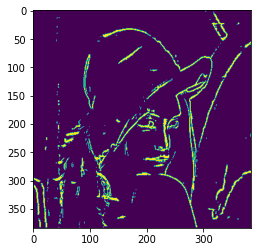

In [67]:
plt.imshow(y_pred)

### 2.3 Segmentation et détection de contours 

Dans cette partie nous allons comparer la sortie obtenue par le réseau unet (spécialisé dans de la détection de contours) et la sortie du réseau unet ré-entraîné pour réaliser de la détection de contours

In [86]:
import torchvision.models.densenet
#On télécharge le modèle pré-entraîné
net = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /home/smussard/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [87]:
import numpy as np
from PIL import Image
from torchvision import transforms
current_path = os.getcwd()
input_image = cv2.imread(current_path + "/lena.png",  cv2.IMREAD_COLOR )
m, s = np.mean(input_image, axis=(0, 1)), np.std(input_image, axis=(0, 1))
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=m, std=s),
    transforms.Resize((256,256))
    
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    net = net.to('cuda')

with torch.no_grad():
    output = net(input_batch)


In [71]:
res = torch.round(output[0]).cpu().detach().numpy()
res= np.swapaxes(res , 0,1)
res = np.swapaxes(res, 1,2)

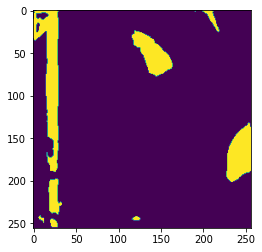

In [72]:
plt.imshow(res)

### 2.4 Test en faisant des transformation d'une image

Floutage d'une image

In [73]:
current_path = os.getcwd()
input_image = cv2.imread(current_path+"/lena.png",  cv2.IMREAD_COLOR )
#input_image = torch.from_numpy(input_image)

def add_noise(inputs,noise_factor=0.3):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

In [74]:
net = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)
net.encoder1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
current_path = os.getcwd()
path = current_path+"/weights_unet_updated.pt"
net.load_state_dict(torch.load(path))

Using cache found in /home/smussard/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


<All keys matched successfully>

In [75]:
noise_imgs = [add_noise(torchvision.transforms.ToTensor()(input_image),0.05)]


In [76]:
noise_imgs = noise_imgs[0][0:1,:,:]
noise_imgs = torch.unsqueeze(noise_imgs, 0)

In [77]:
noise_imgs = torchvision.transforms.Resize((384,384))(noise_imgs)

On passe l'image dans le réseau

In [78]:
outputs = net(noise_imgs)

On change les dimensions pour avoir les canaux sur la 3ème dimension

In [79]:
labels = outputs.cpu().detach().numpy()
labels = labels[0,:,:,:]
labels = np.swapaxes(labels, 0, 1)
labels= np.swapaxes(labels, 1,2)

On seuille pour avoir les contours

In [80]:
threshold = 0.1
y_pred = (labels > threshold)

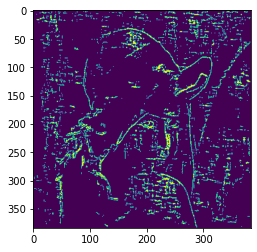

In [81]:
plt.imshow(y_pred)

Image bruitée initiale

In [82]:
noise_imgs = noise_imgs[0].numpy()
noise_imgs = np.swapaxes(noise_imgs, 0,1)
noise_imgs = np.swapaxes(noise_imgs, 1,2)

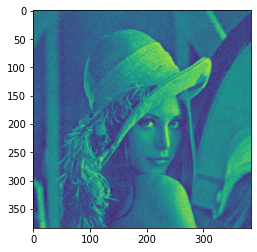

In [83]:
plt.imshow(noise_imgs)